In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Define Paths and Create Directories

In [2]:
data_dir = Path("../data/processed")
models_dir = Path("../models")
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)
figures_dir = results_dir / "figures"
figures_dir.mkdir(exist_ok=True)

Define Helper Functions to Recreate the Featured Dataframe

In [3]:
def create_aligned_dataframe(nwm_df, usgs_df):
    """Aligns NWM forecasts with USGS observations."""
    nwm_df = nwm_df.sort_values(by='model_output_valid_time')
    usgs_df = usgs_df.sort_index()
    aligned_df = pd.merge_asof(
        left=nwm_df, right=usgs_df,
        left_on='model_output_valid_time', right_index=True,
        direction='nearest', tolerance=pd.Timedelta(minutes=30)
    )
    aligned_df.dropna(subset=['USGSFlowValue'], inplace=True)
    aligned_df = aligned_df.rename(columns={
        'streamflow_value': 'NWM_streamflow', 'USGSFlowValue': 'USGS_streamflow'
    })
    return aligned_df

def create_features(df):
    """Creates all necessary features and the error column."""
    df['error'] = df['NWM_streamflow'] - df['USGS_streamflow']
    valid_time = df['model_output_valid_time']
    df['month'] = valid_time.dt.month
    df['day_of_year'] = valid_time.dt.dayofyear
    df['hour'] = valid_time.dt.hour
    feature_cols = [
        'error', 'NWM_streamflow', 'USGS_streamflow',
        'lead_time', 'month', 'day_of_year', 'hour'
    ]
    df_featured = df[['model_output_valid_time'] + feature_cols].set_index('model_output_valid_time')
    return df_featured

Load Data and Recreate Featured Dataframe for each Station

In [5]:
station_data = {}
for station_name in ['station1', 'station2']:
    # Load the raw component data
    nwm_df = pd.read_parquet(data_dir / f"{station_name}_nwm.parquet")
    usgs_df = pd.read_parquet(data_dir / f"{station_name}_usgs.parquet")
    
    # Ensure model_output_valid_time is timezone-aware (UTC)
    nwm_df['model_output_valid_time'] = nwm_df['model_output_valid_time'].dt.tz_localize('UTC')
    # Recreate the full, unscaled dataframe
    aligned_df = create_aligned_dataframe(nwm_df, usgs_df)
    featured_df = create_features(aligned_df)

    # Load the sequenced data for modeling
    data_for_modeling = np.load(data_dir / f'{station_name}_processed_for_modeling.npz')
    # Load the scaler
    with open(data_dir / f'scaler_{station_name}.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    station_data[station_name] = {
        'X_test': data_for_modeling['X_test'],
        'scaler': scaler,
        'original_featured_df': featured_df
    }

Define the Metrics Calculation Function

In [6]:
def calculate_metrics(observed, forecasted):
    """Calculates CC, RMSE, PBIAS, and NSE."""
    observed, forecasted = np.array(observed), np.array(forecasted)
    cc = np.corrcoef(observed, forecasted)[0, 1]
    rmse = np.sqrt(np.mean((forecasted - observed) ** 2))
    pbias = 100 * np.sum(forecasted - observed) / np.sum(observed)
    nse = 1 - (np.sum((forecasted - observed) ** 2) / np.sum((observed - np.mean(observed)) ** 2))
    return {'CC': cc, 'RMSE': rmse, 'PBIAS': pbias, 'NSE': nse}

print("Setup complete. All data, models, and scalers are ready.")

Setup complete. All data, models, and scalers are ready.


Loop through each model, make predictions, calculate the metrics, visualization loop



///// EVALUATING MODELS FOR station1 /////


--- Processing RNN model ---
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


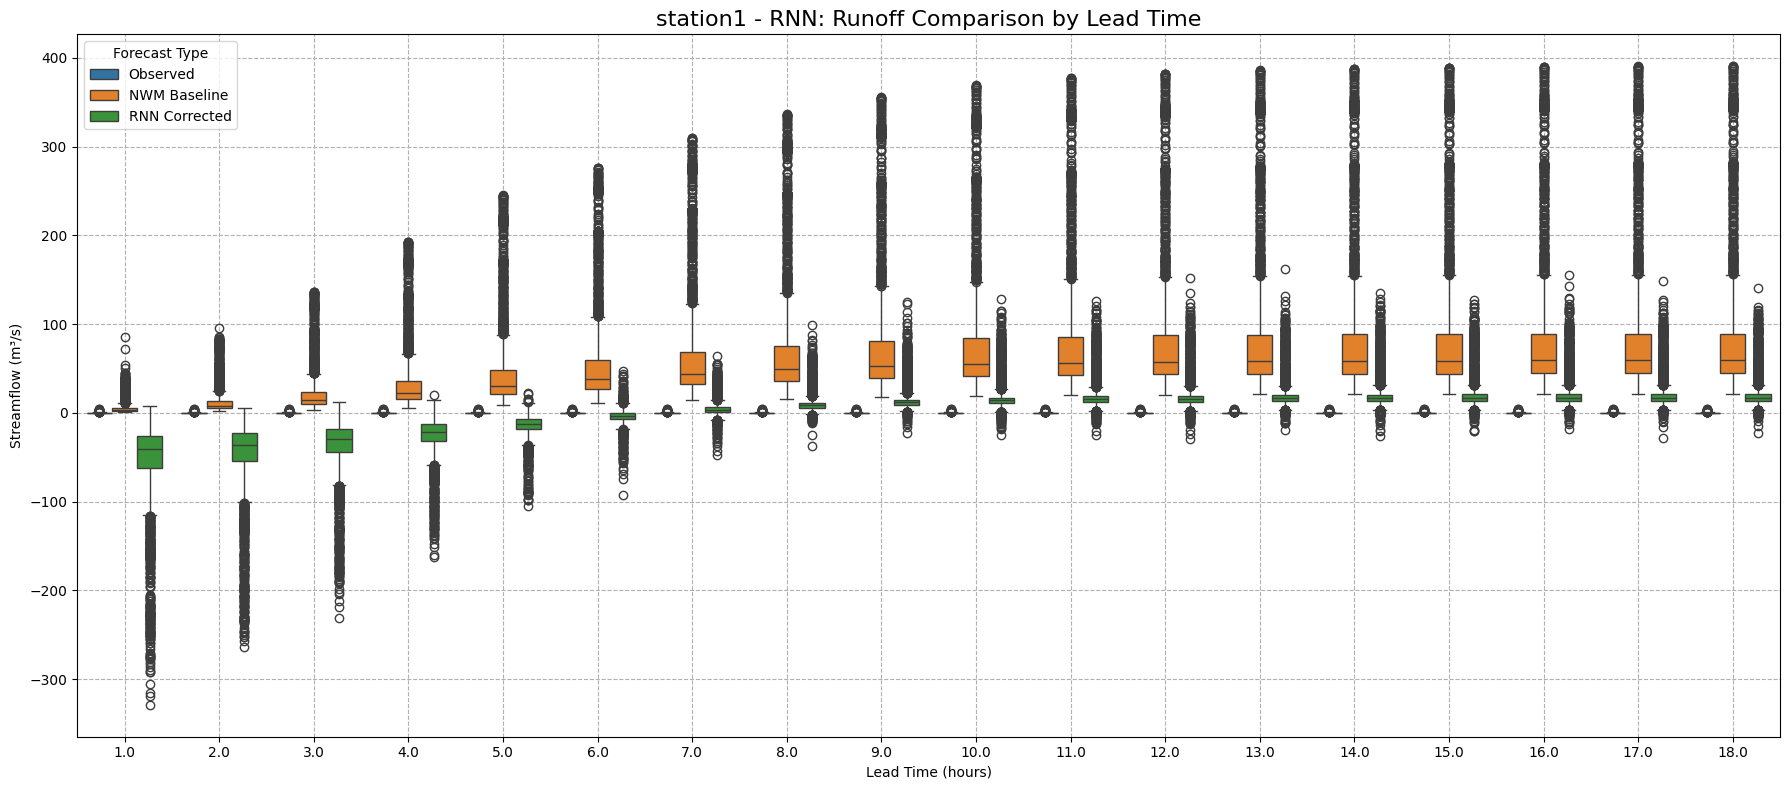

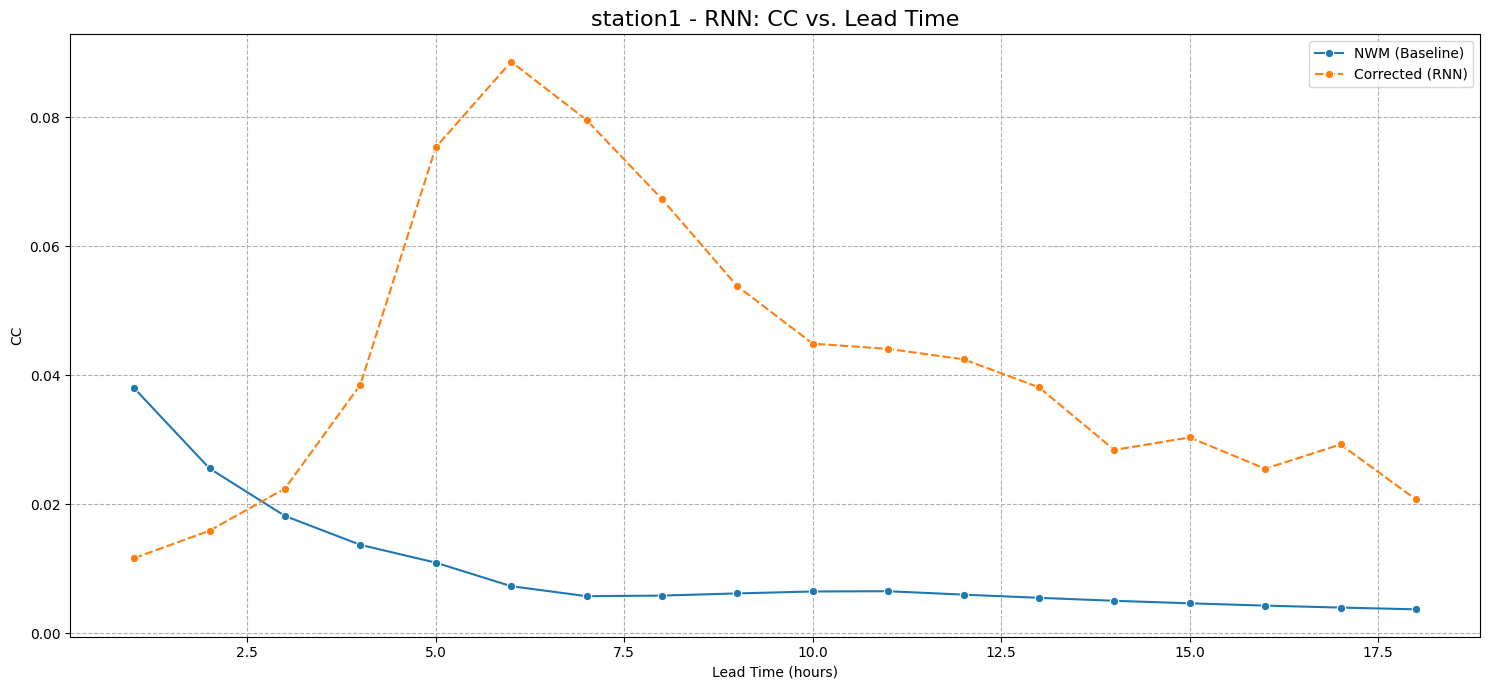

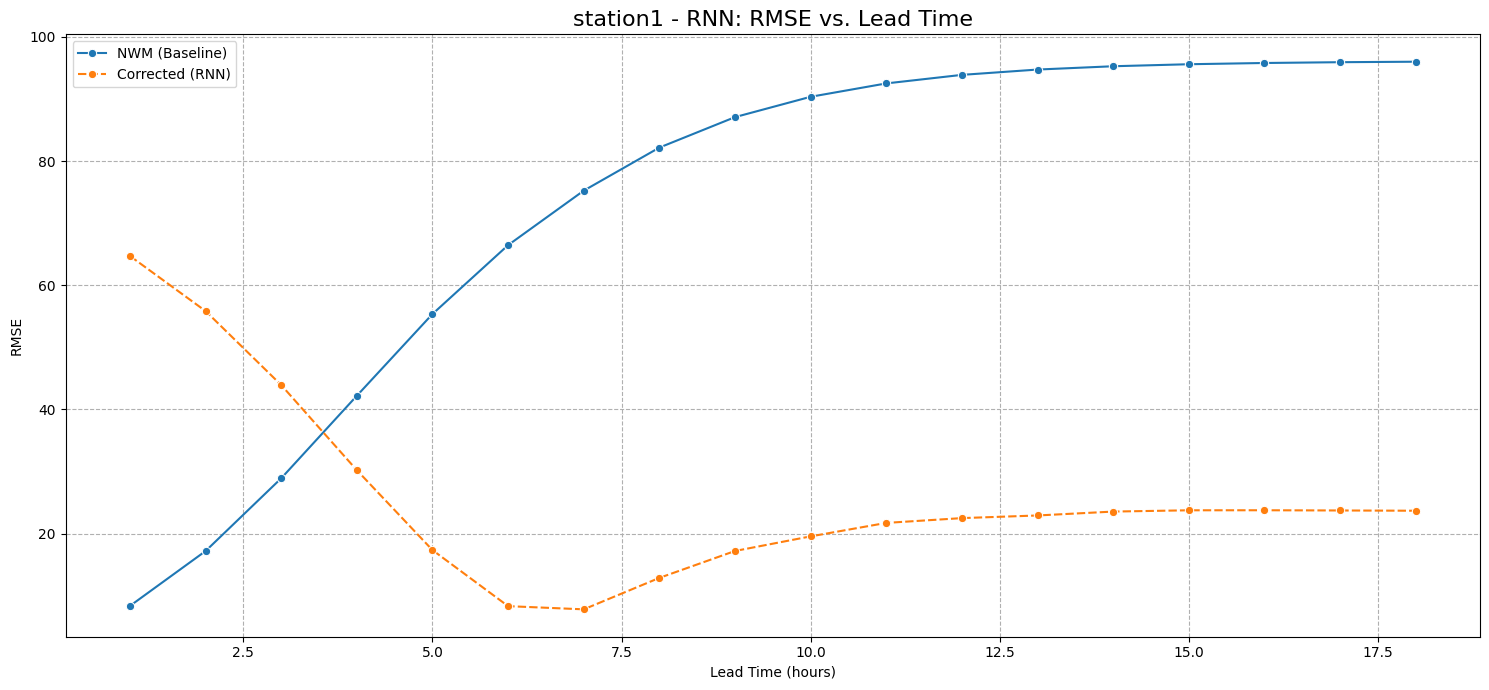

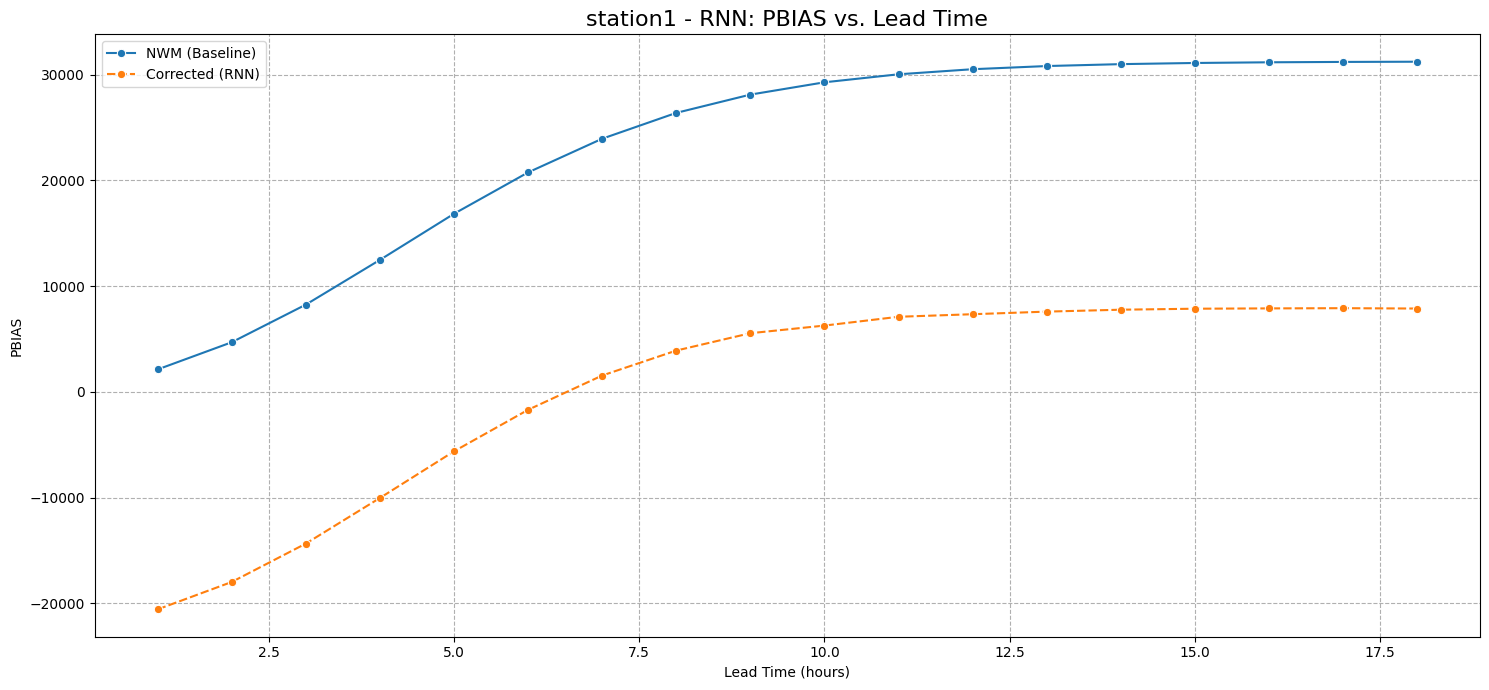

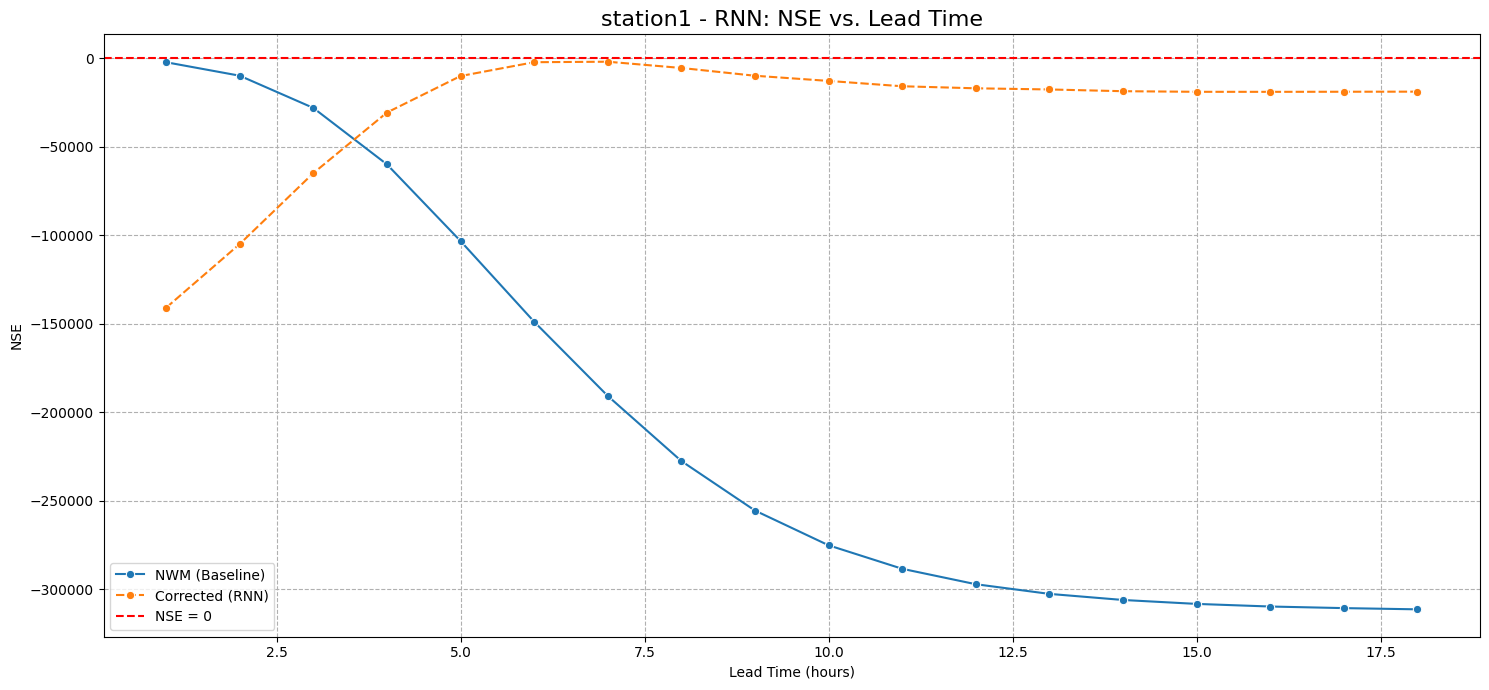

Visualizations complete for RNN.

--- Processing LSTM model ---
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


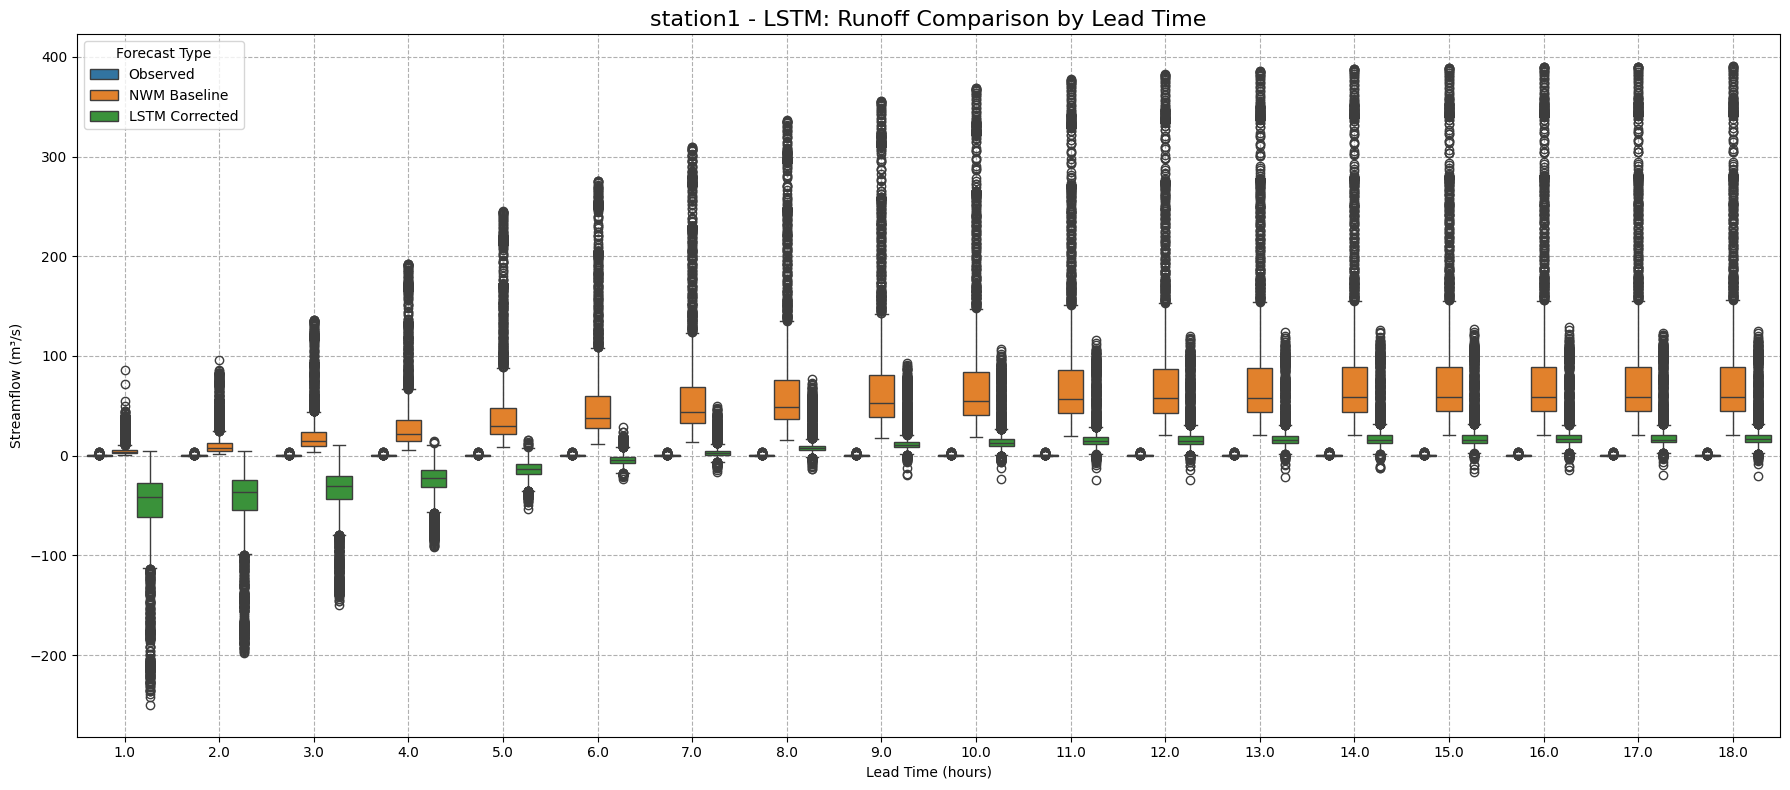

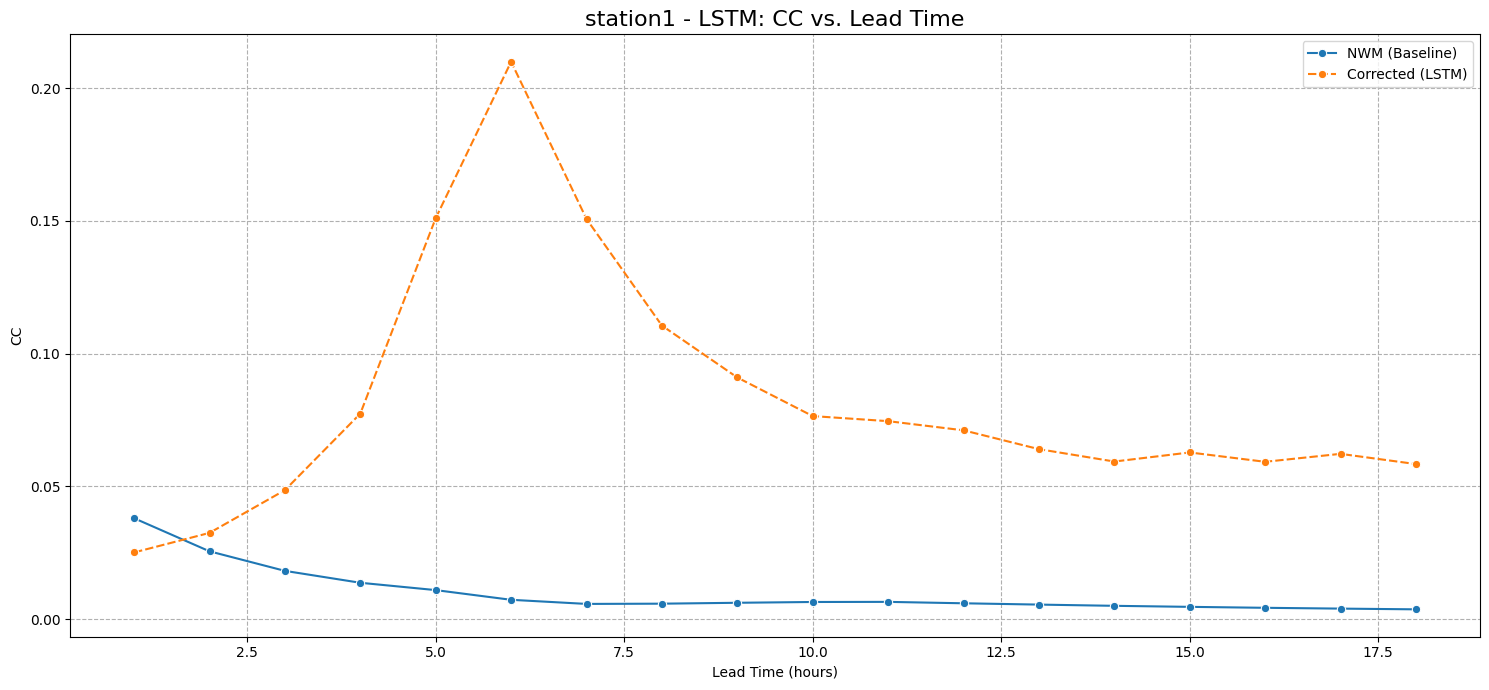

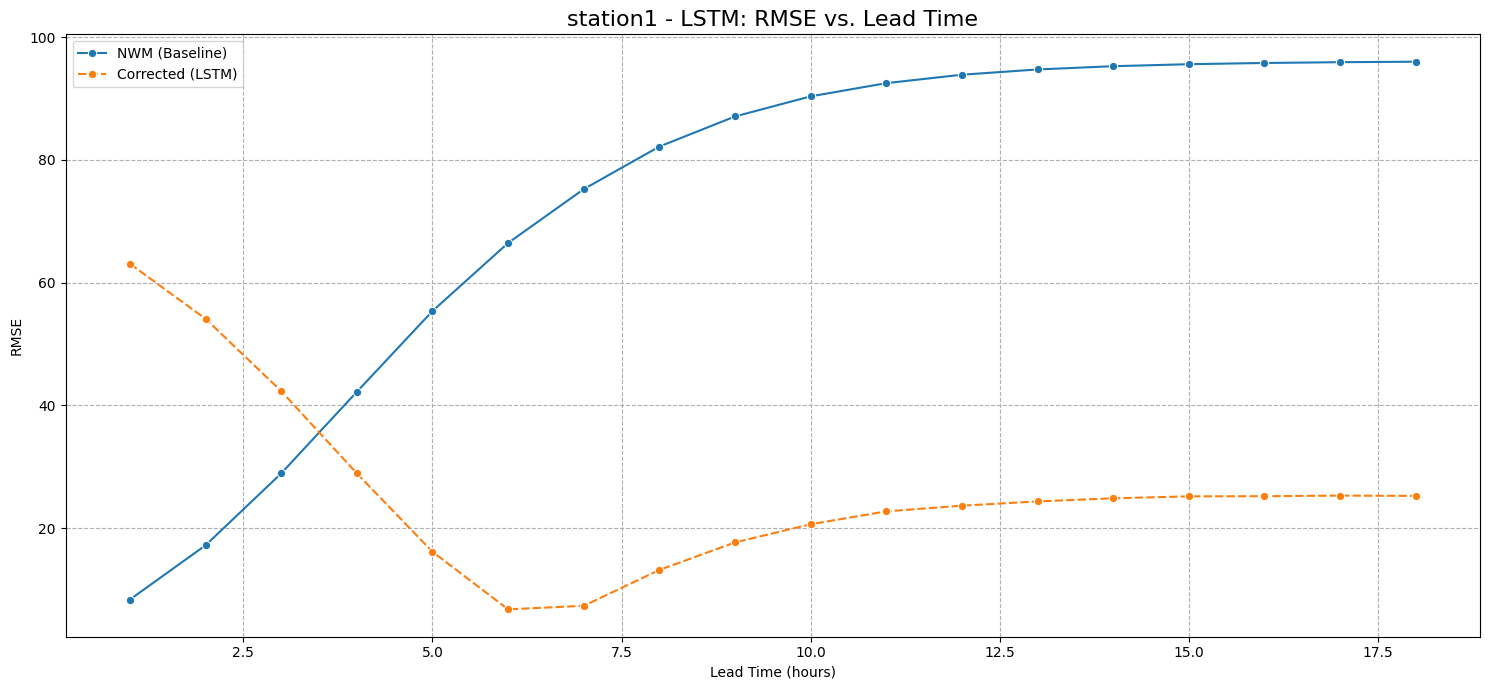

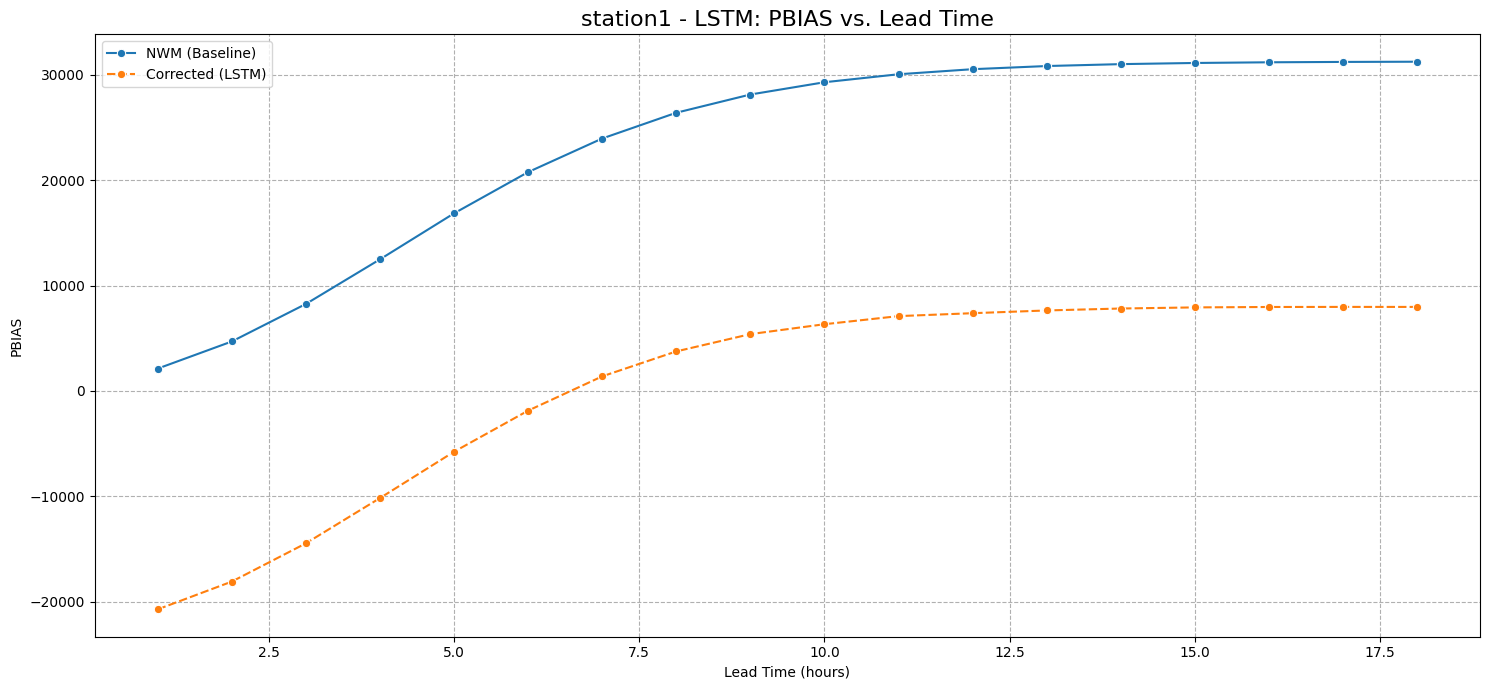

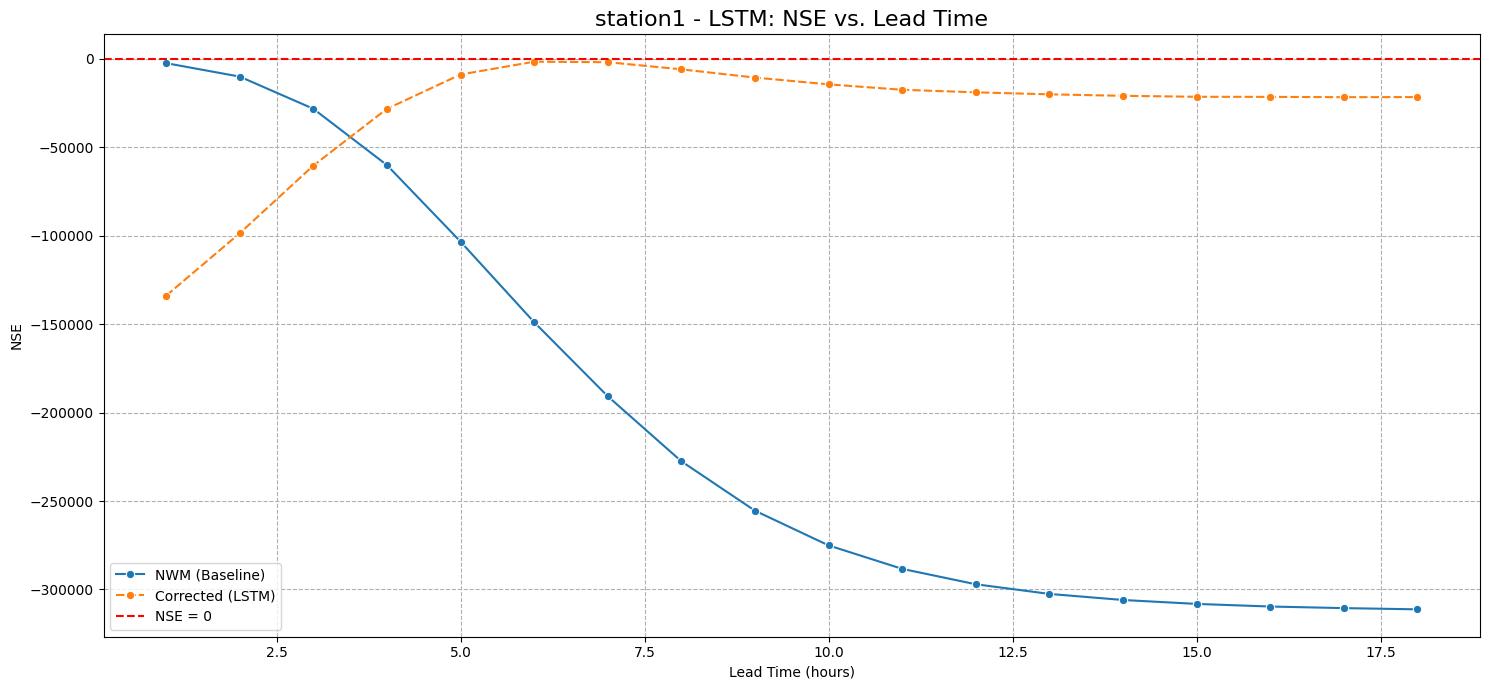

Visualizations complete for LSTM.

--- Processing TRANSFORMER model ---
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step


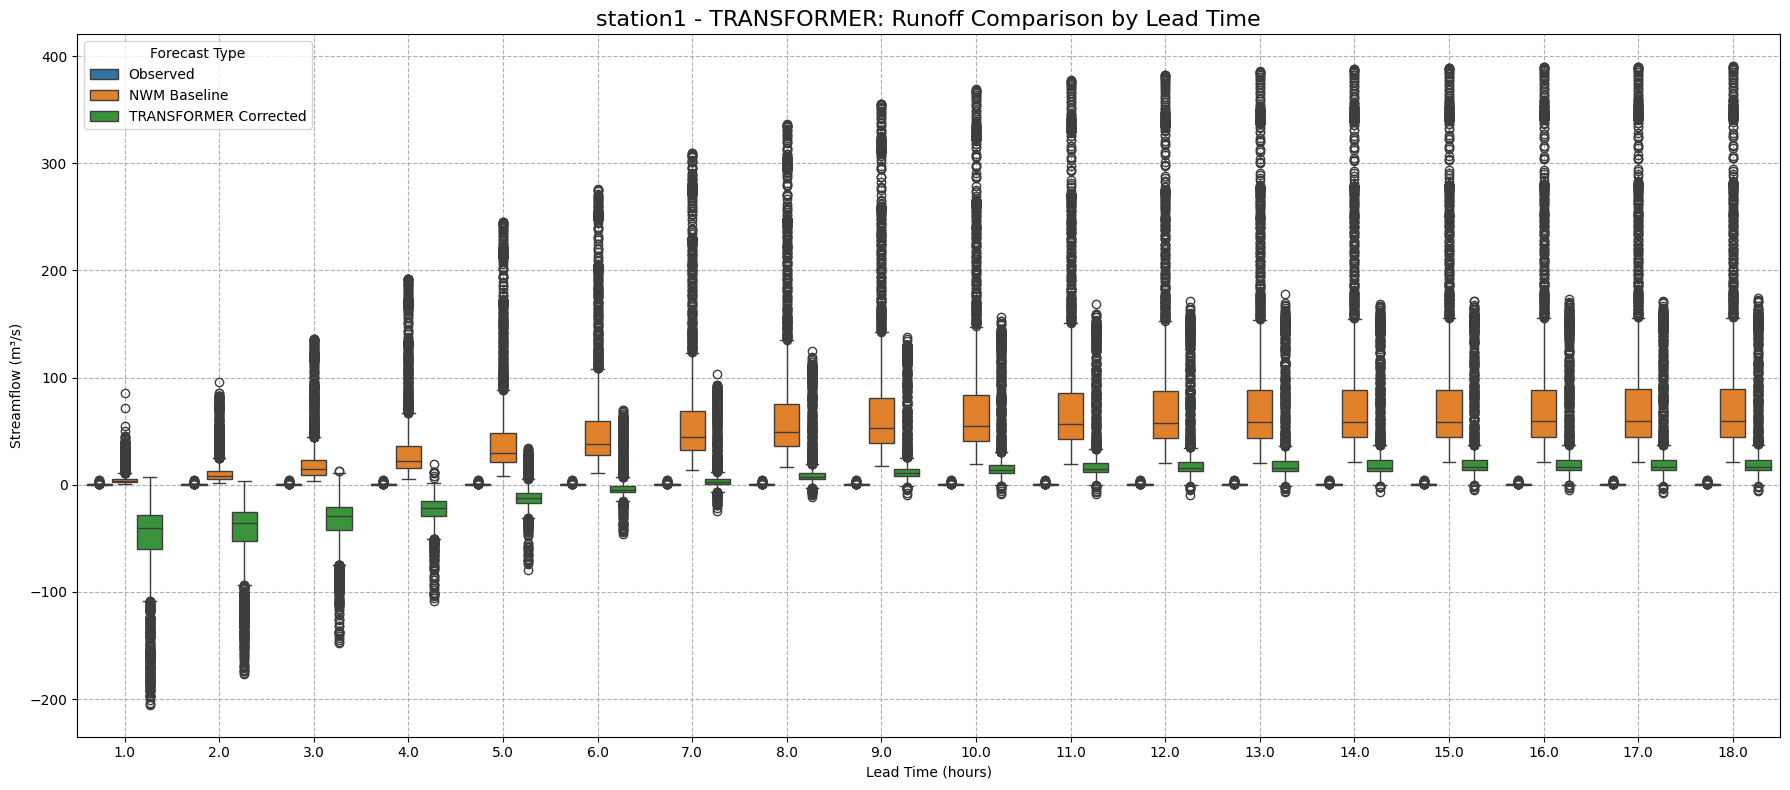

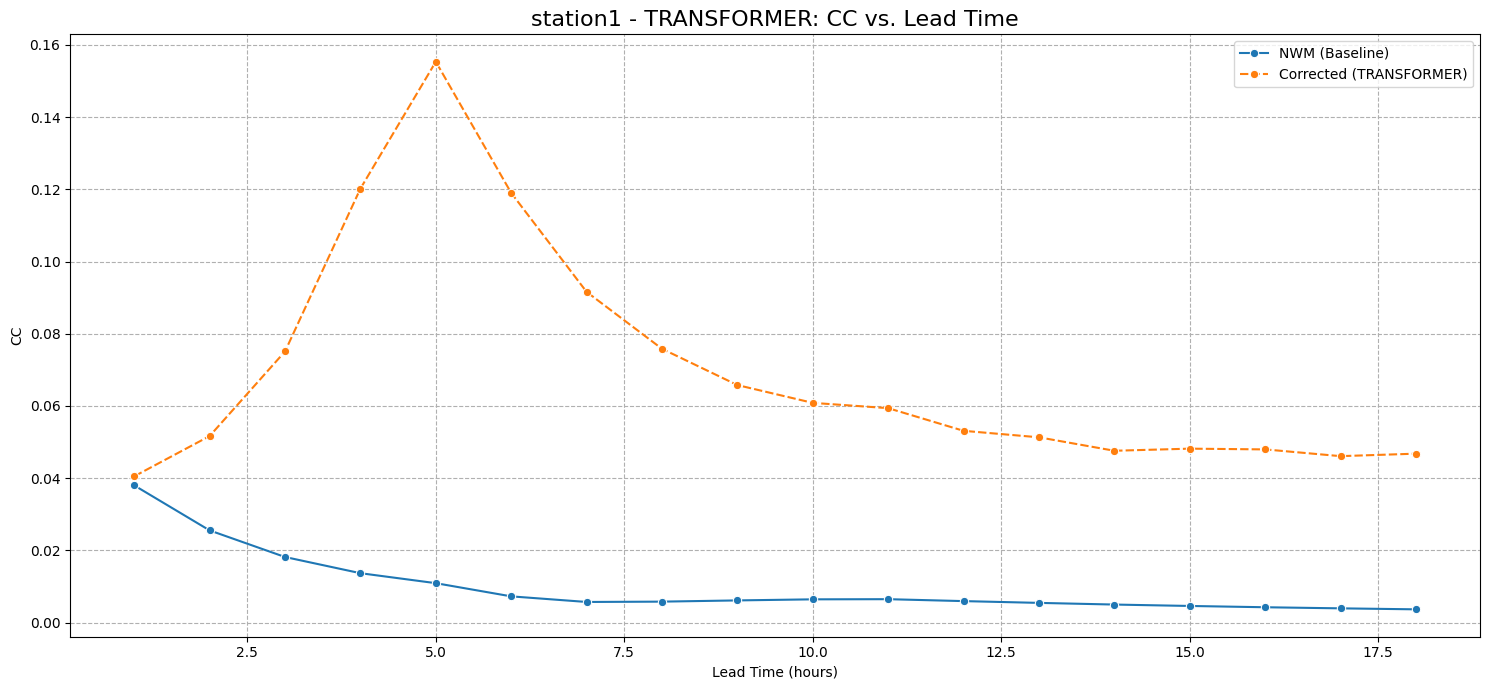

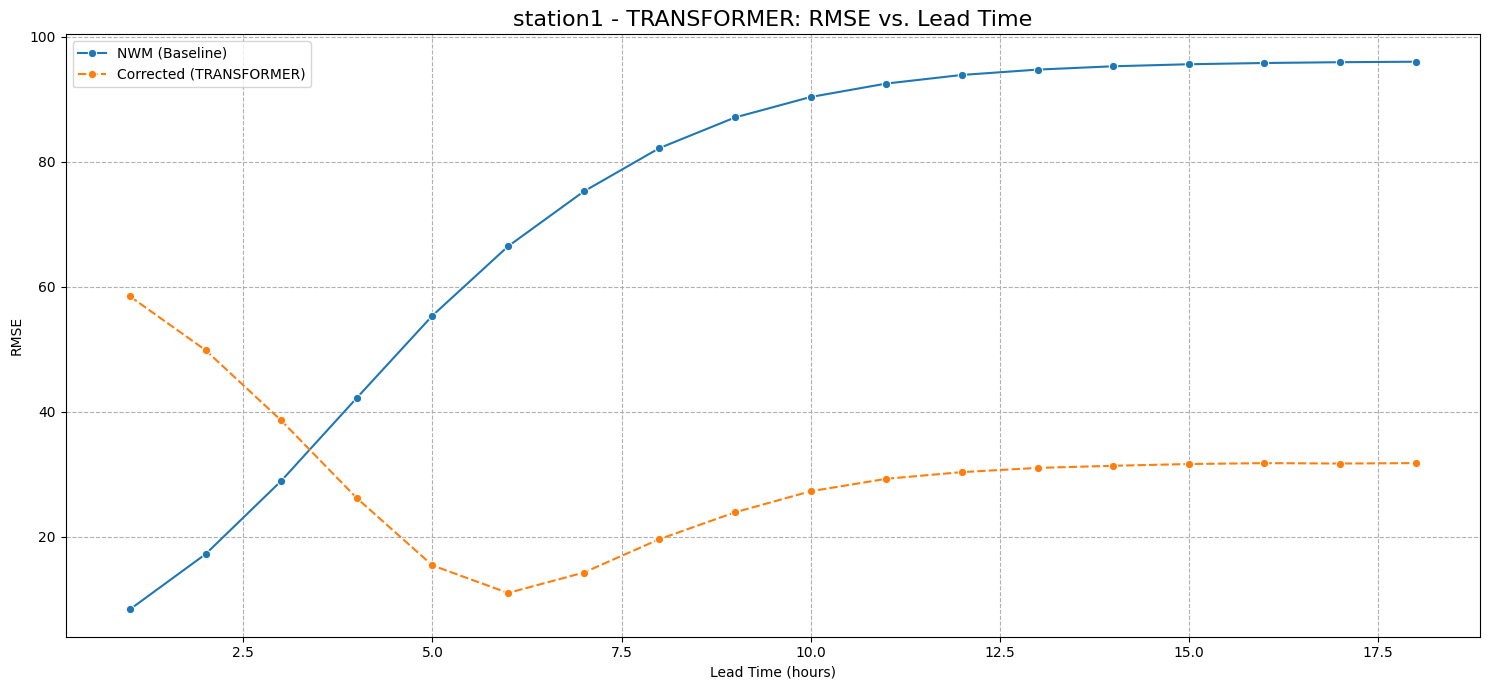

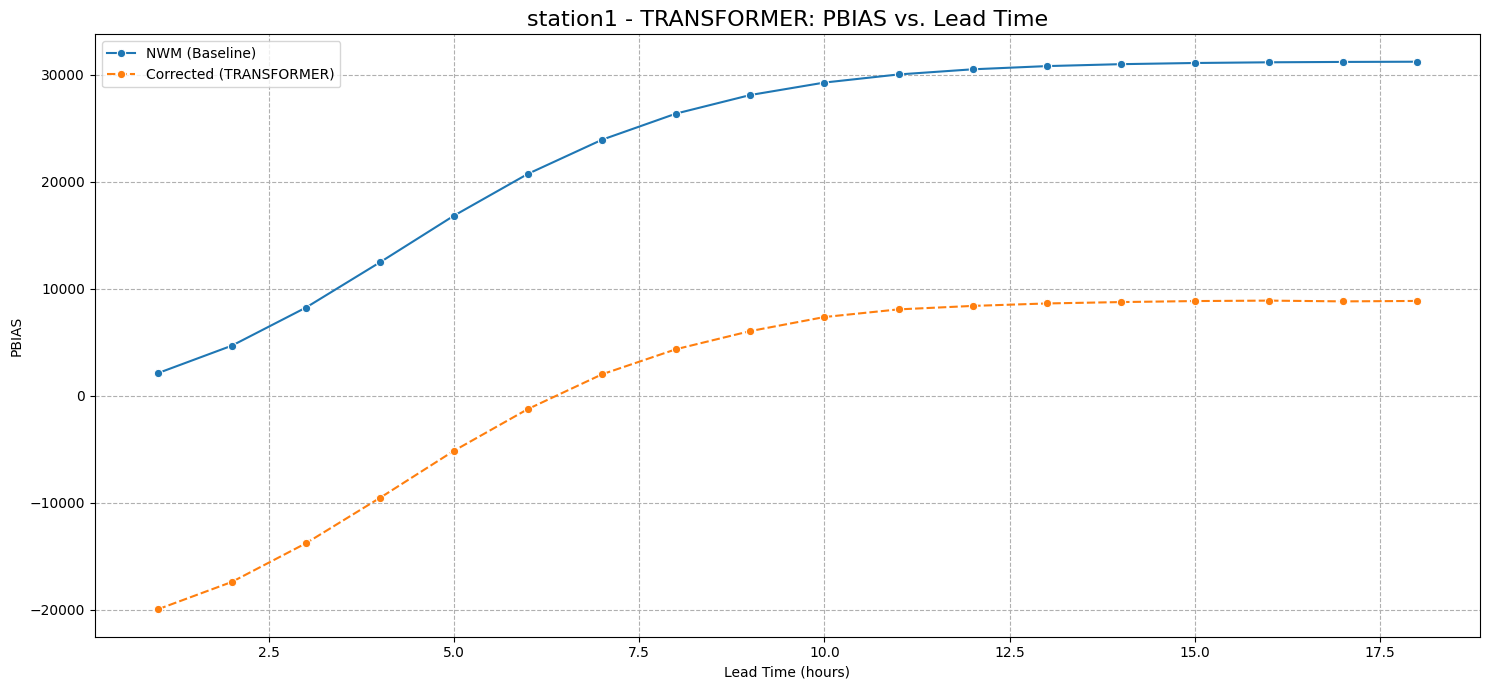

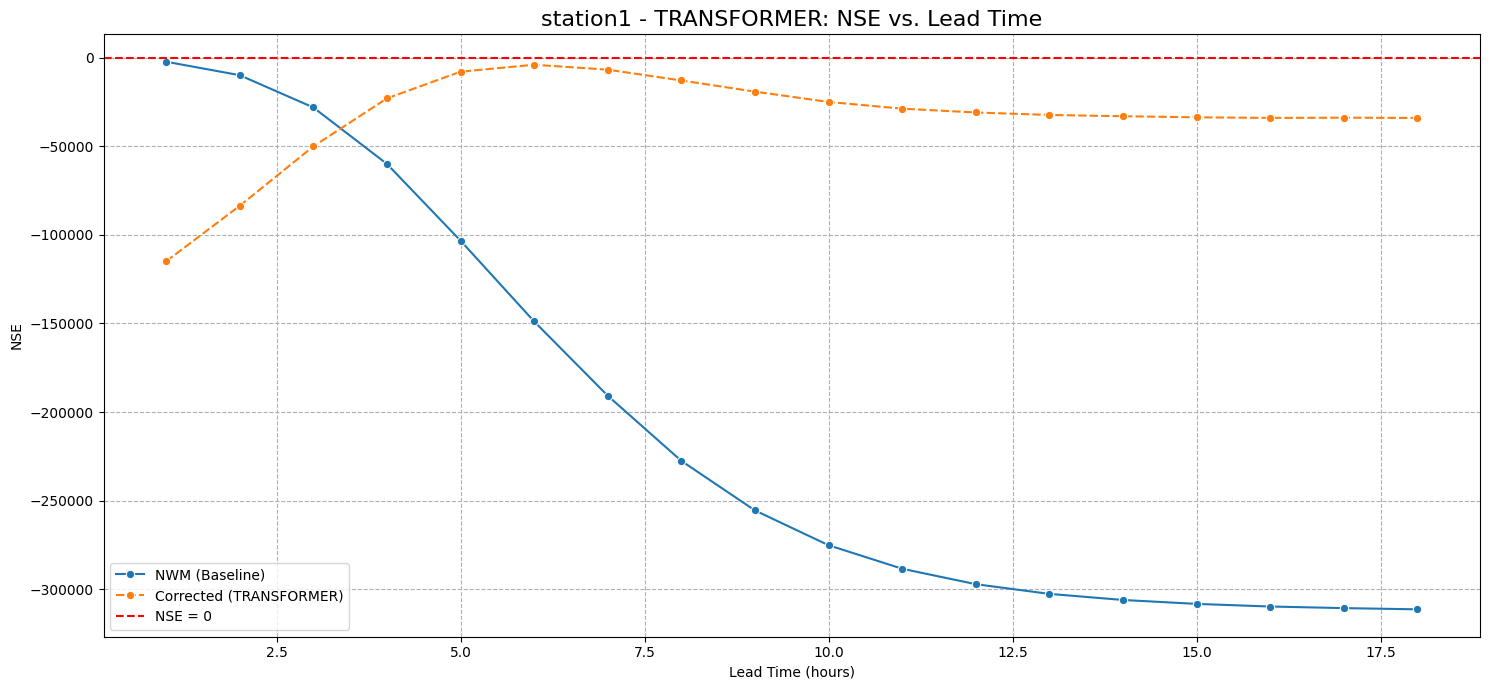

Visualizations complete for TRANSFORMER.


///// EVALUATING MODELS FOR station2 /////


--- Processing RNN model ---
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


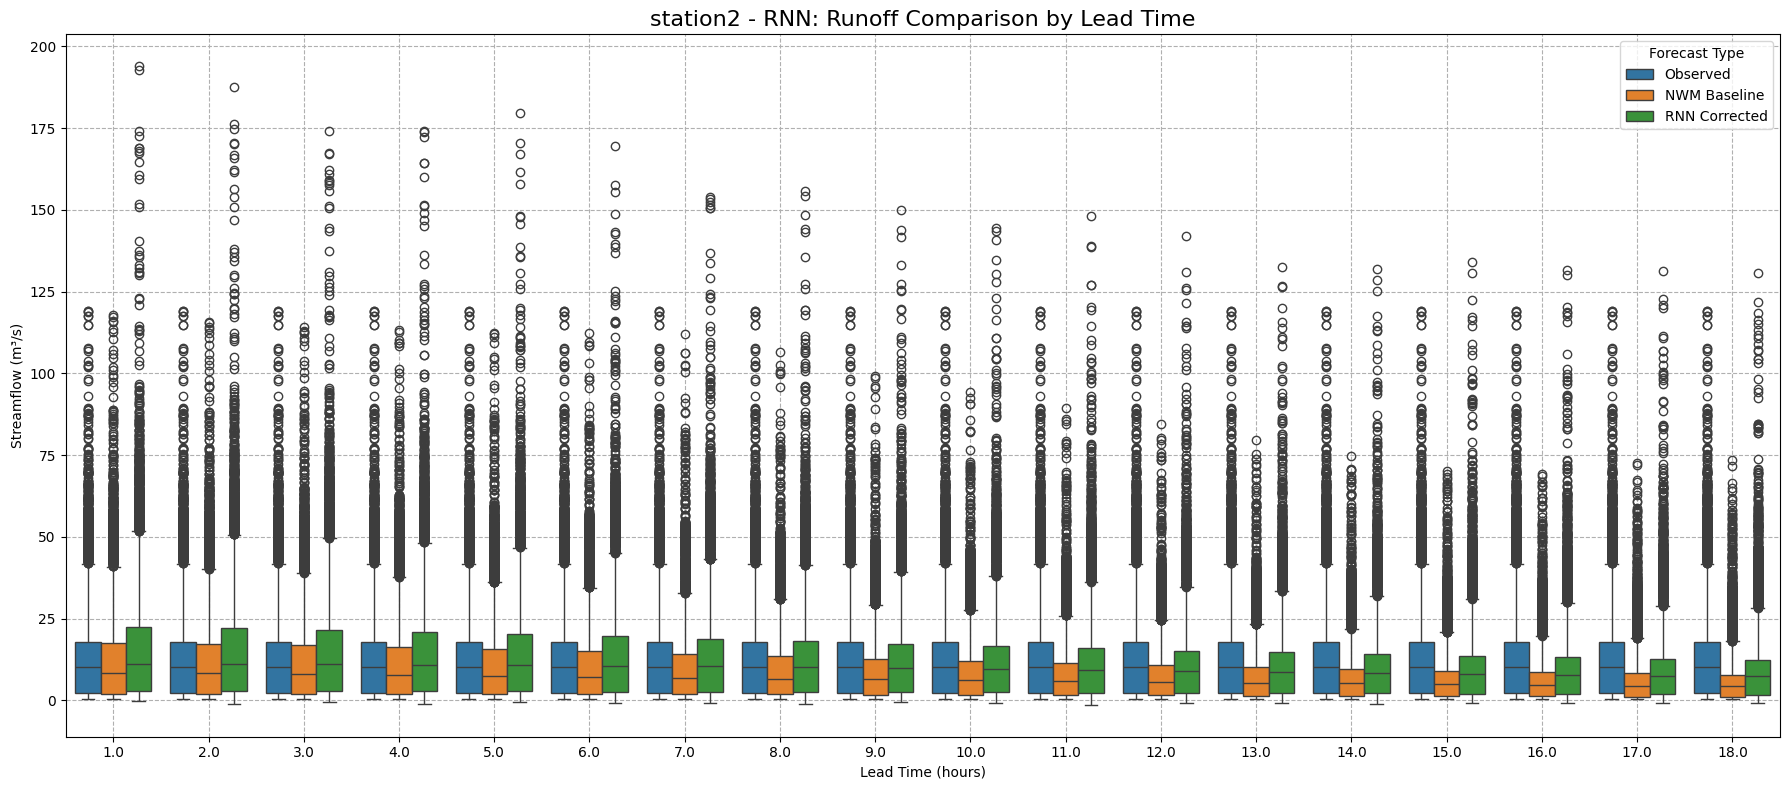

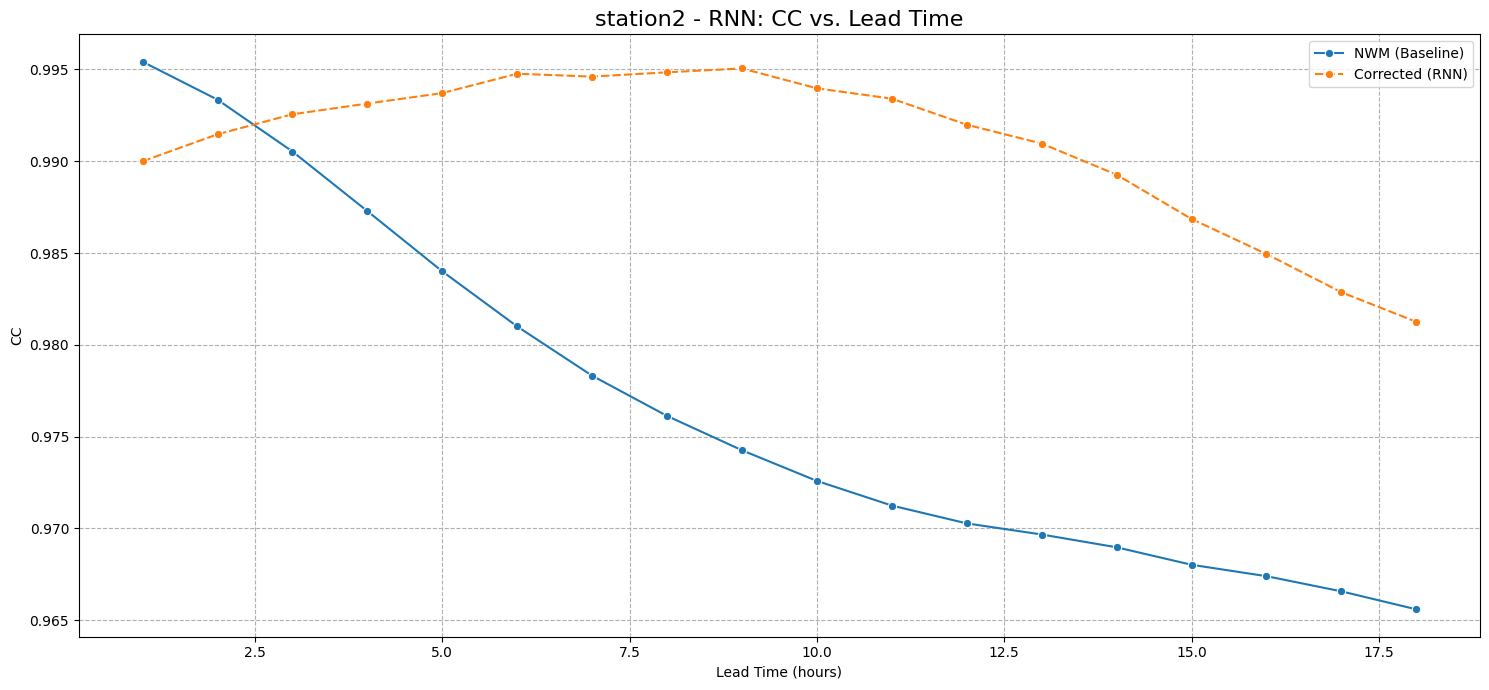

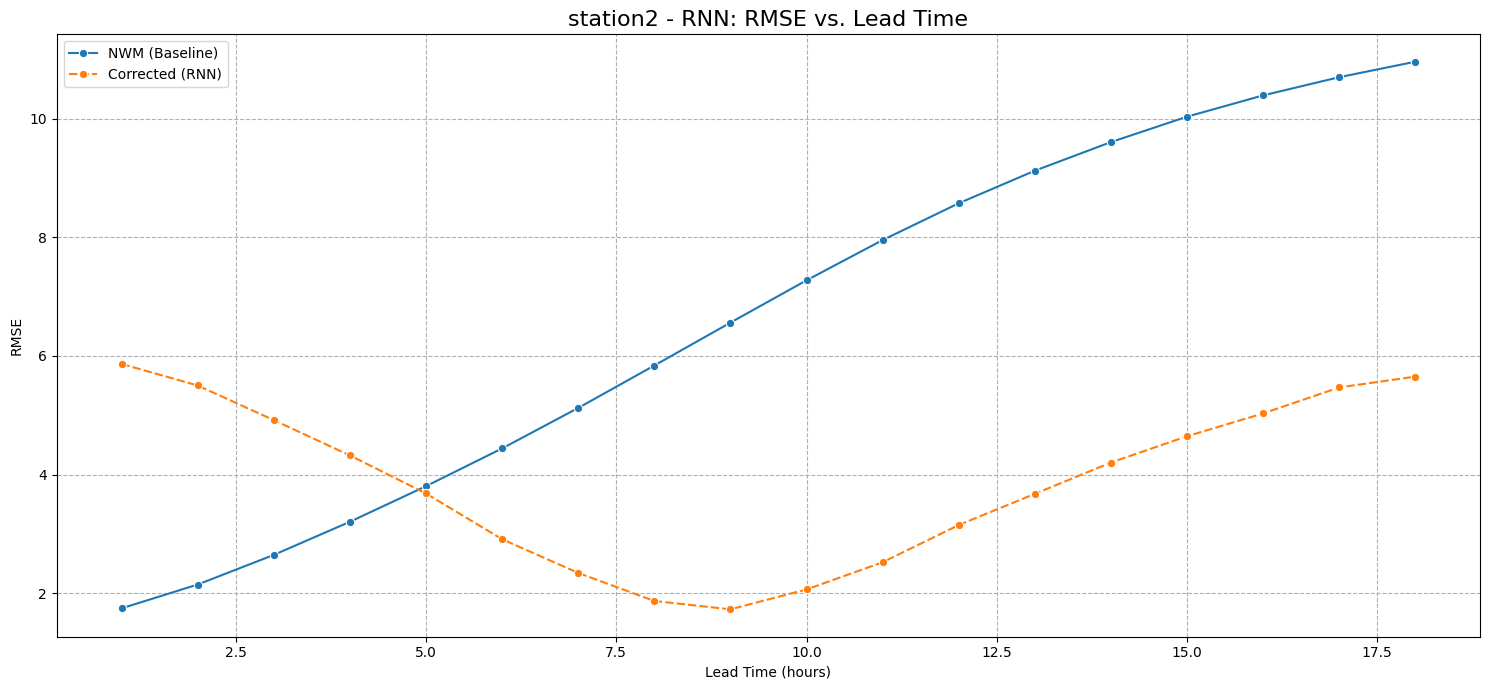

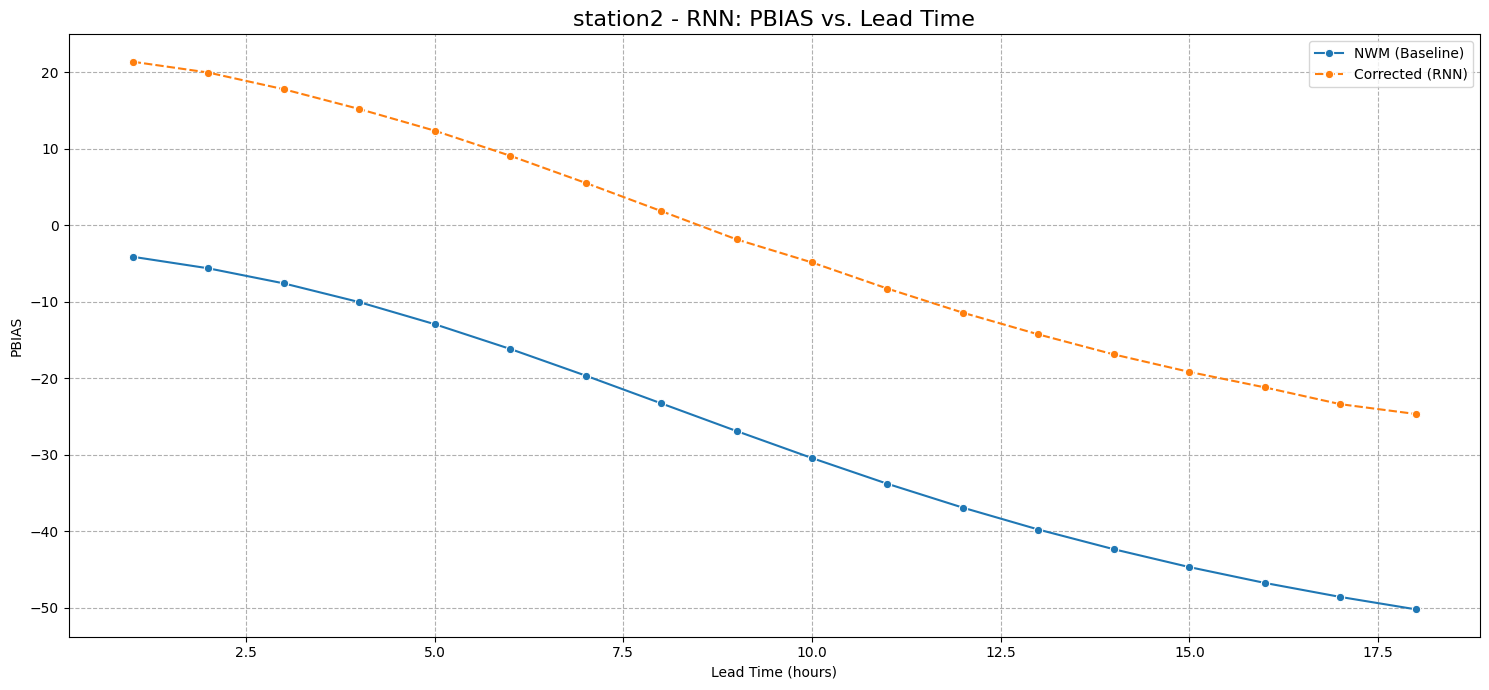

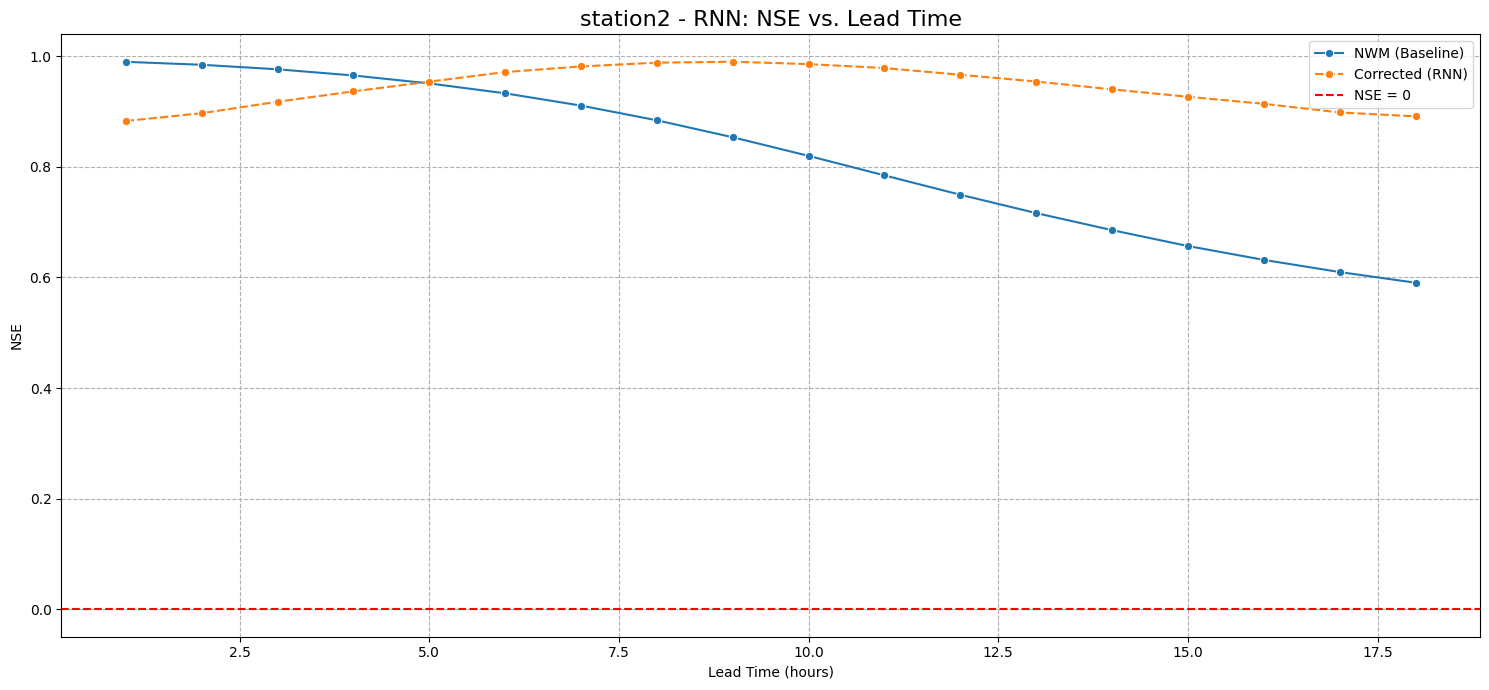

Visualizations complete for RNN.

--- Processing LSTM model ---
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


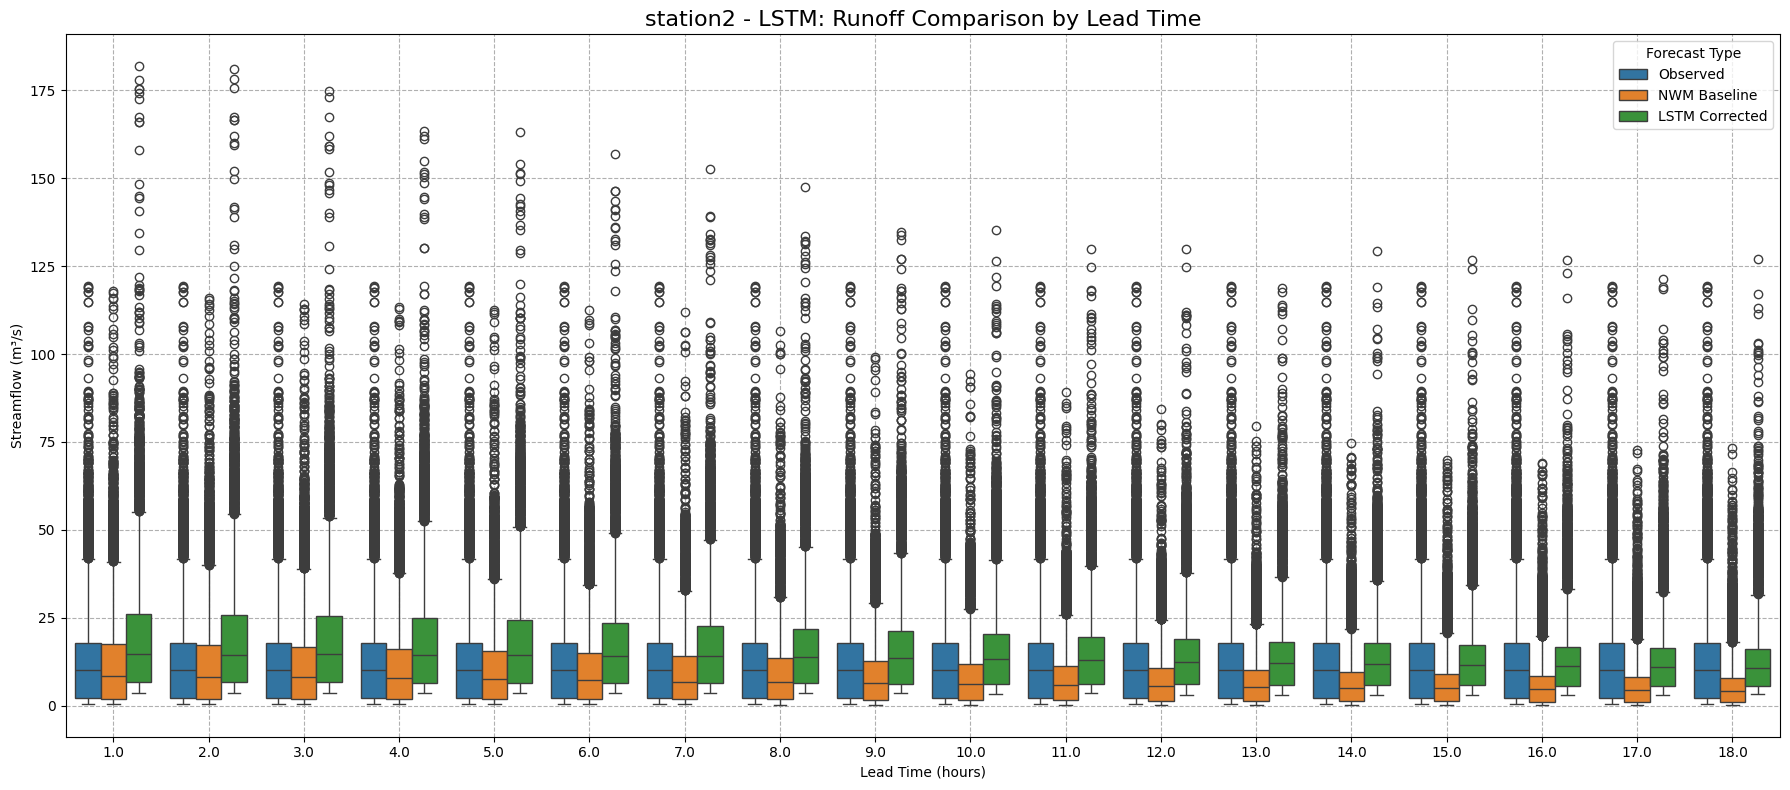

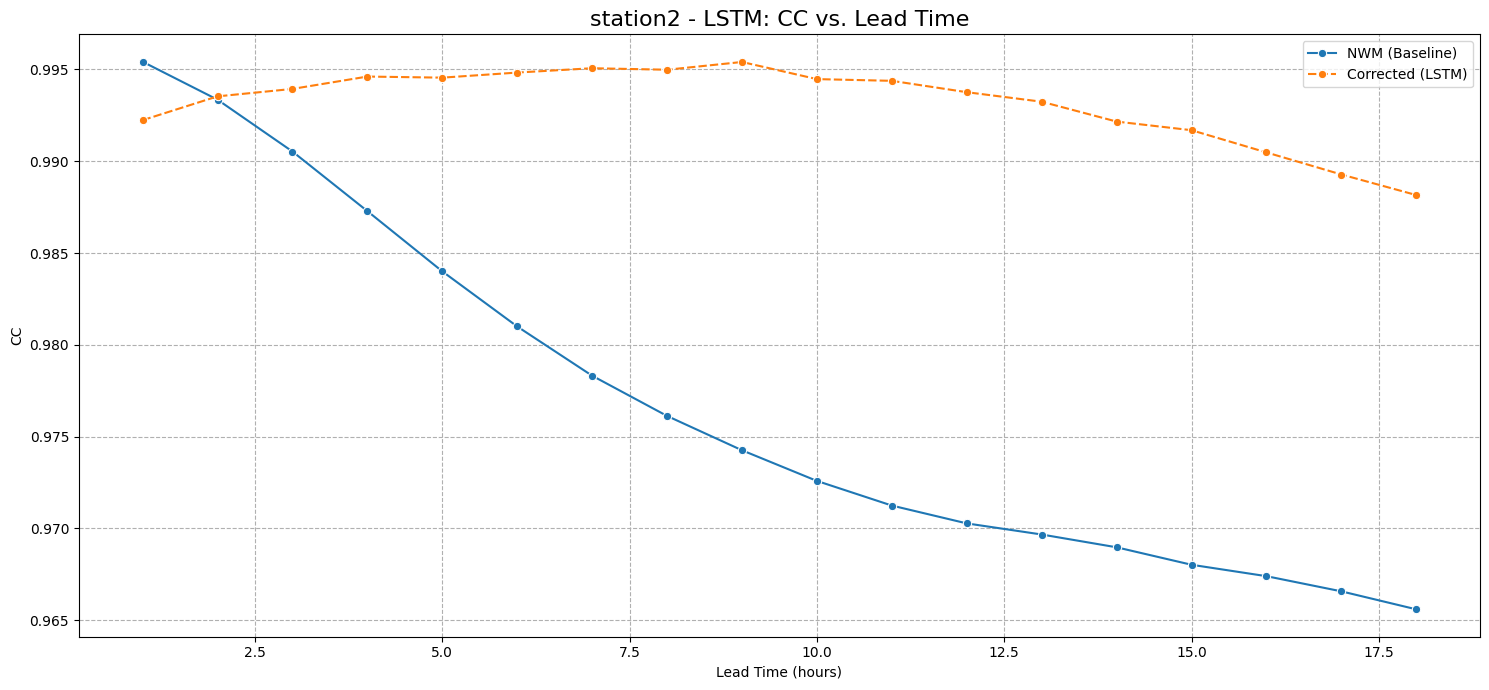

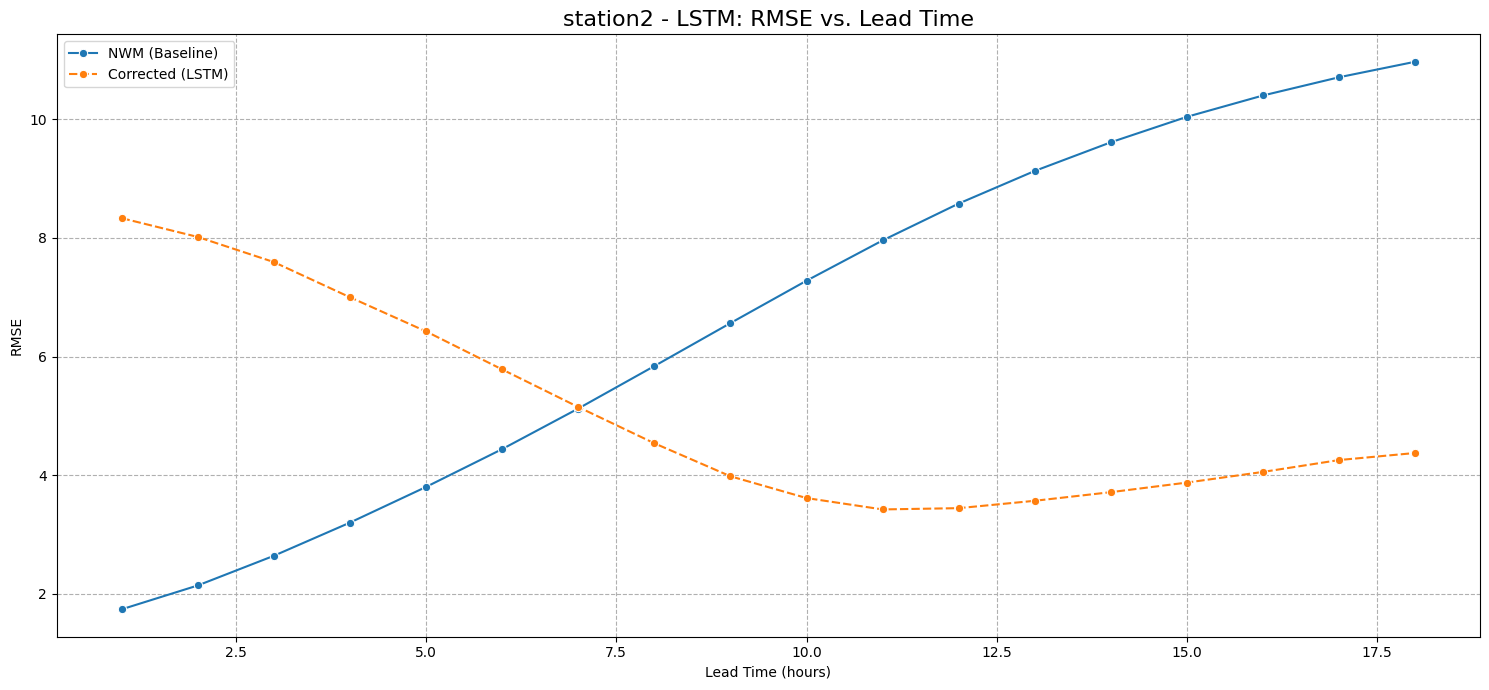

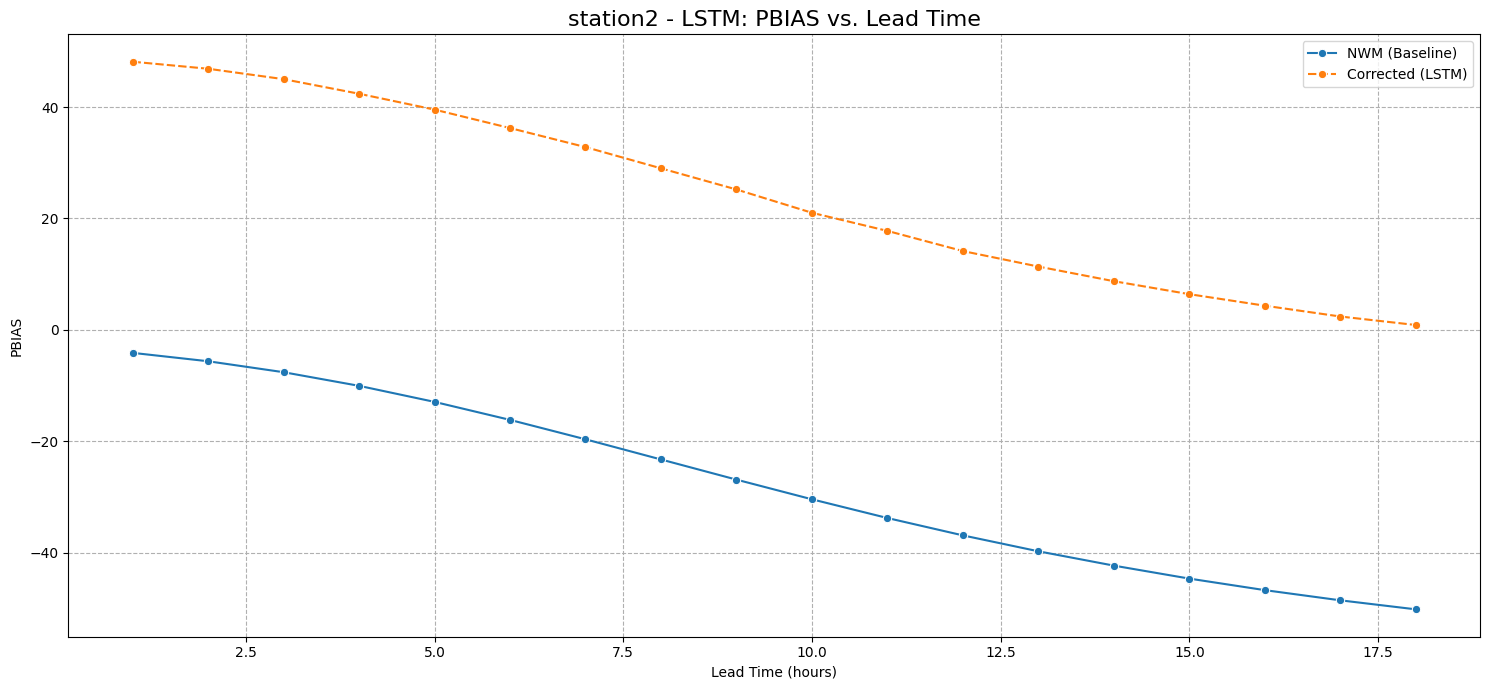

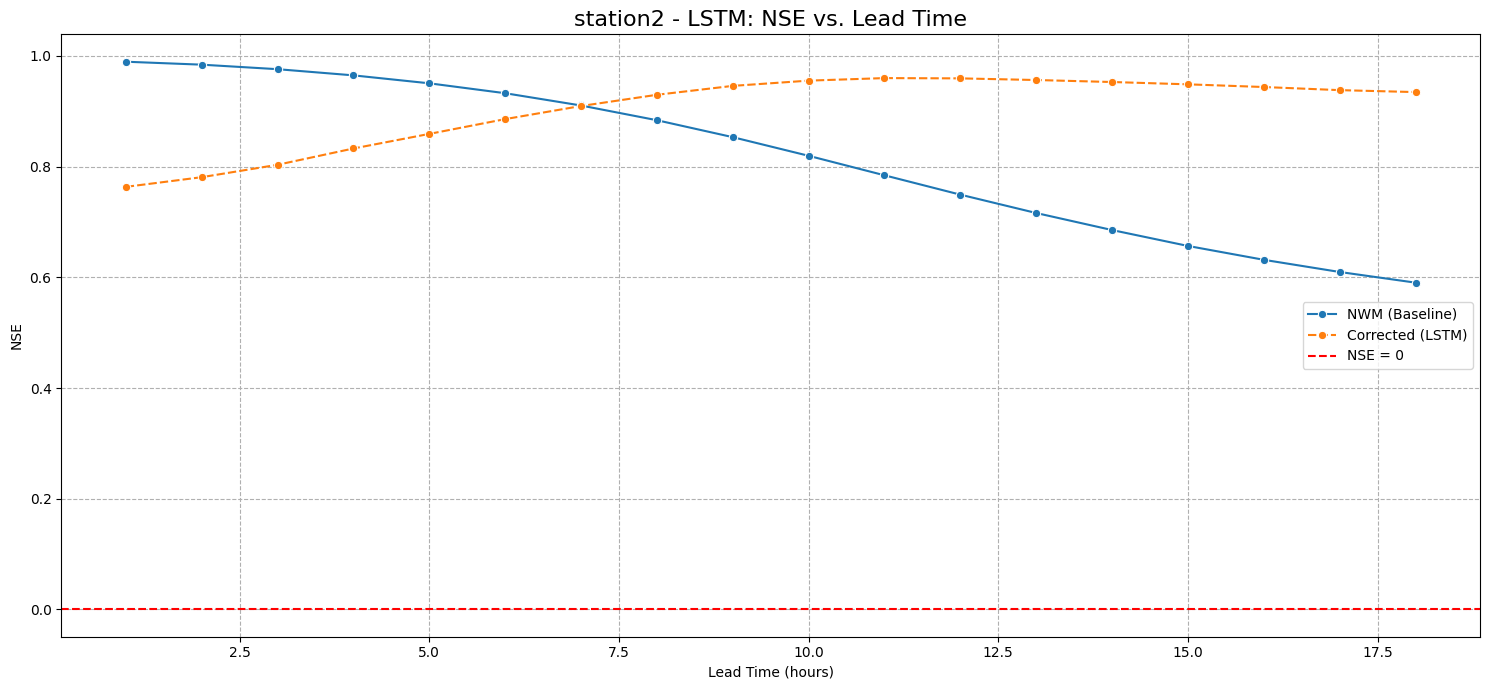

Visualizations complete for LSTM.

--- Processing TRANSFORMER model ---
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step


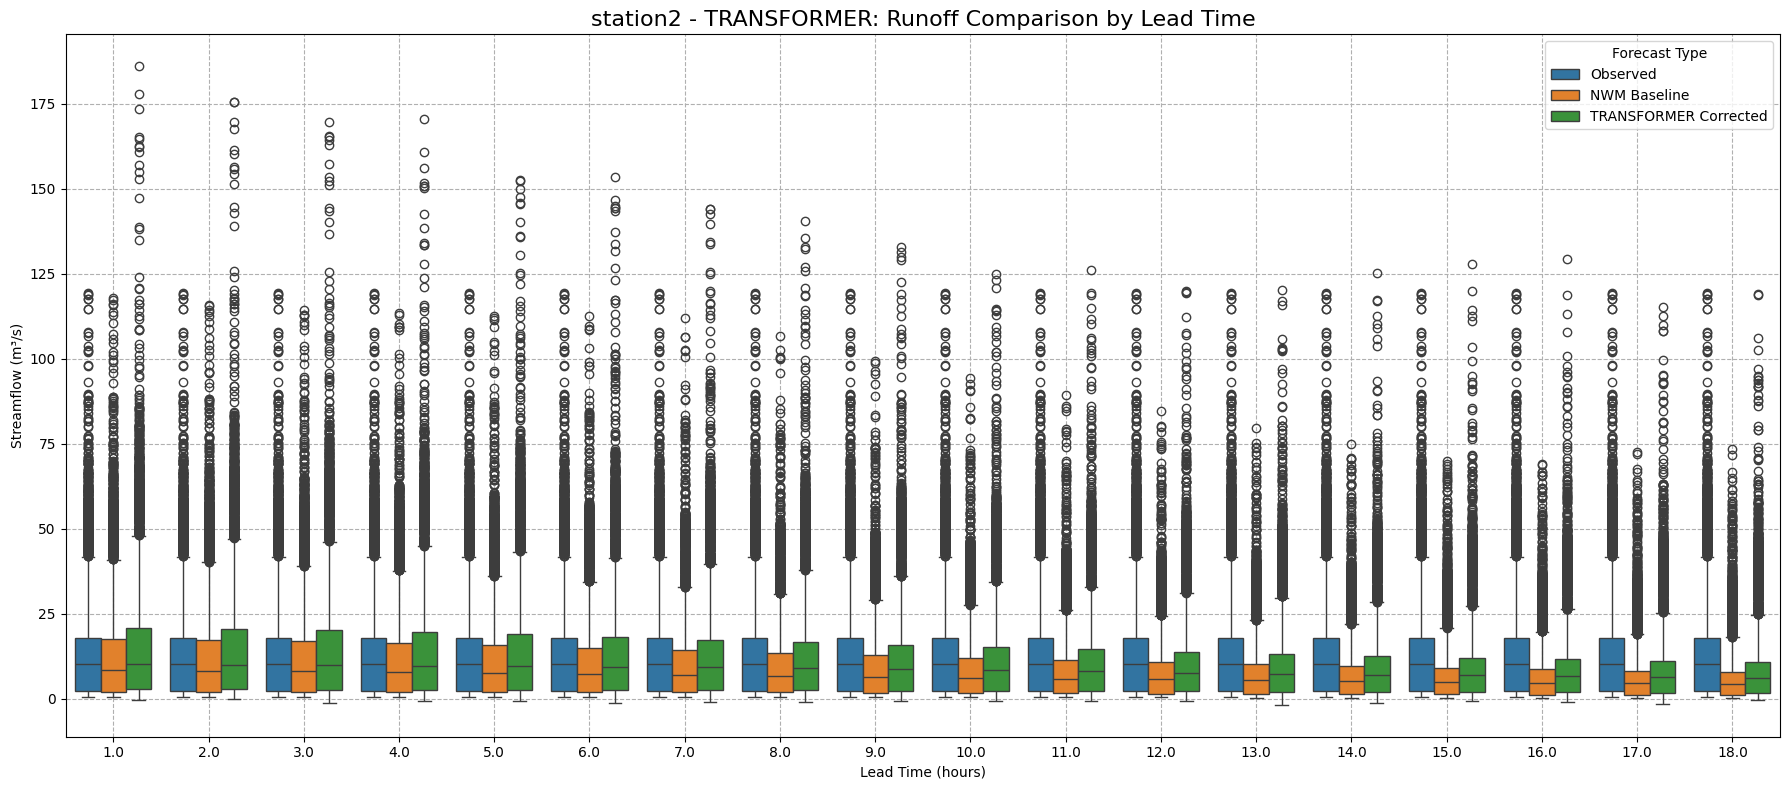

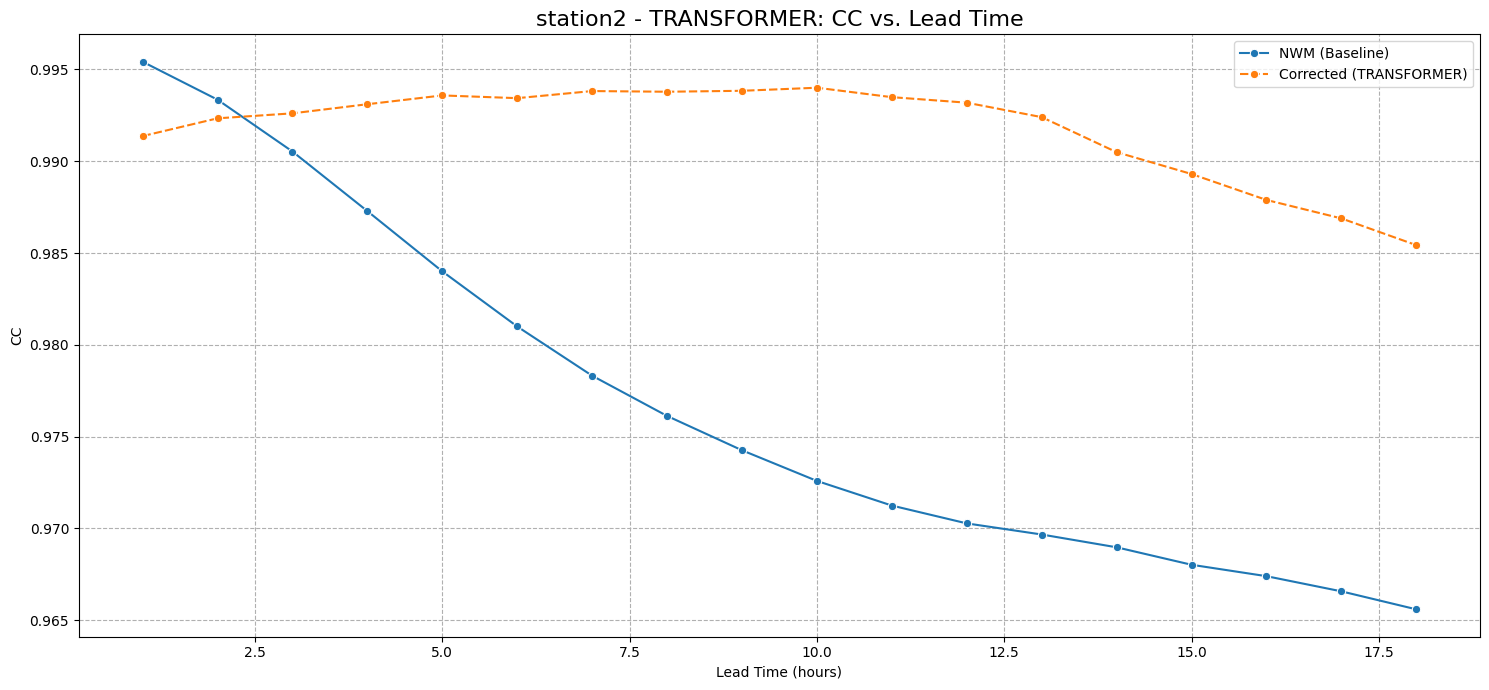

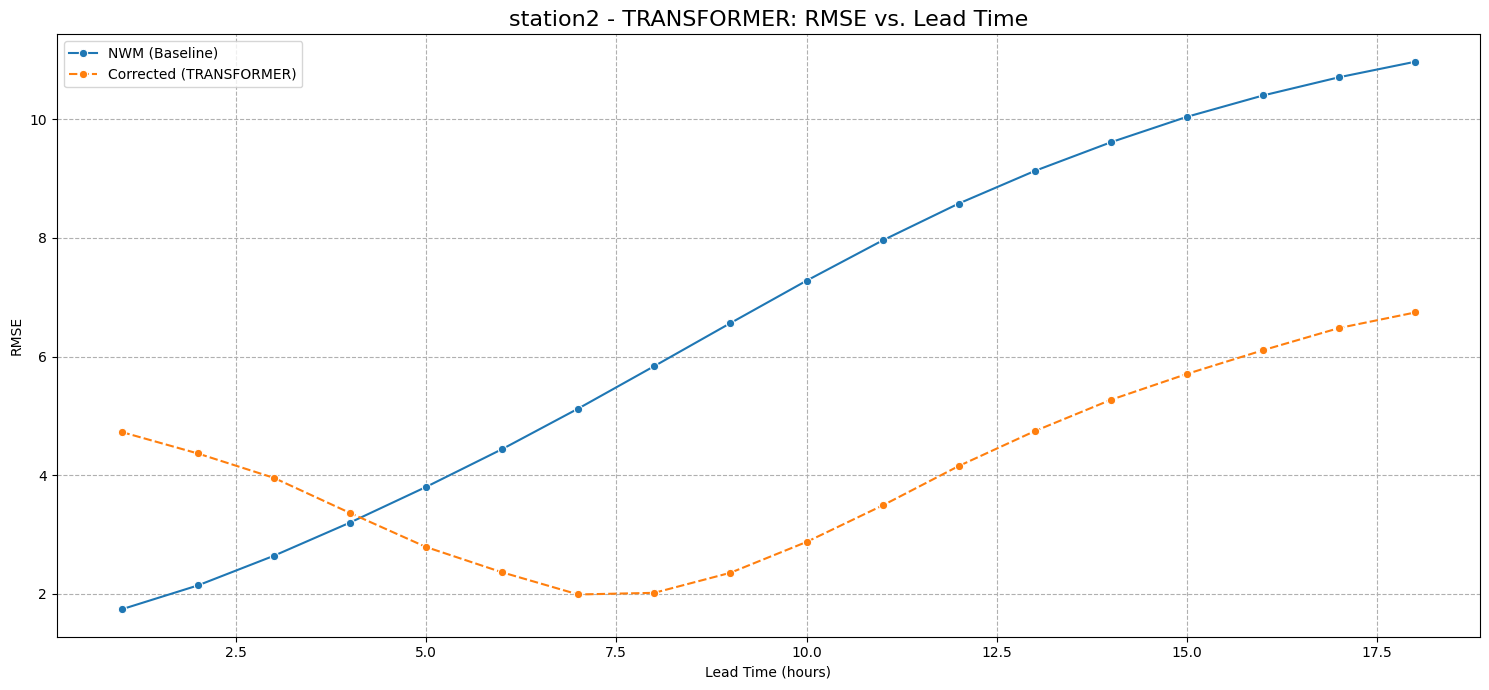

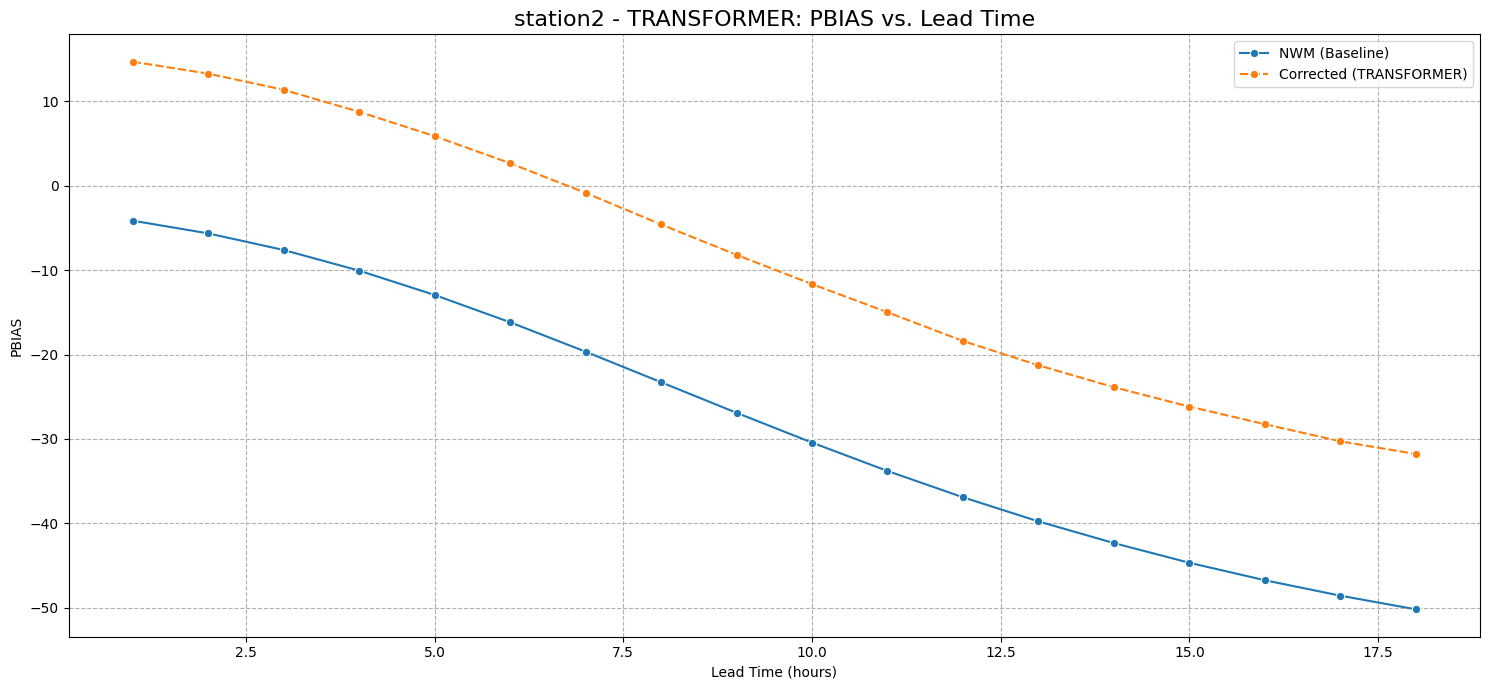

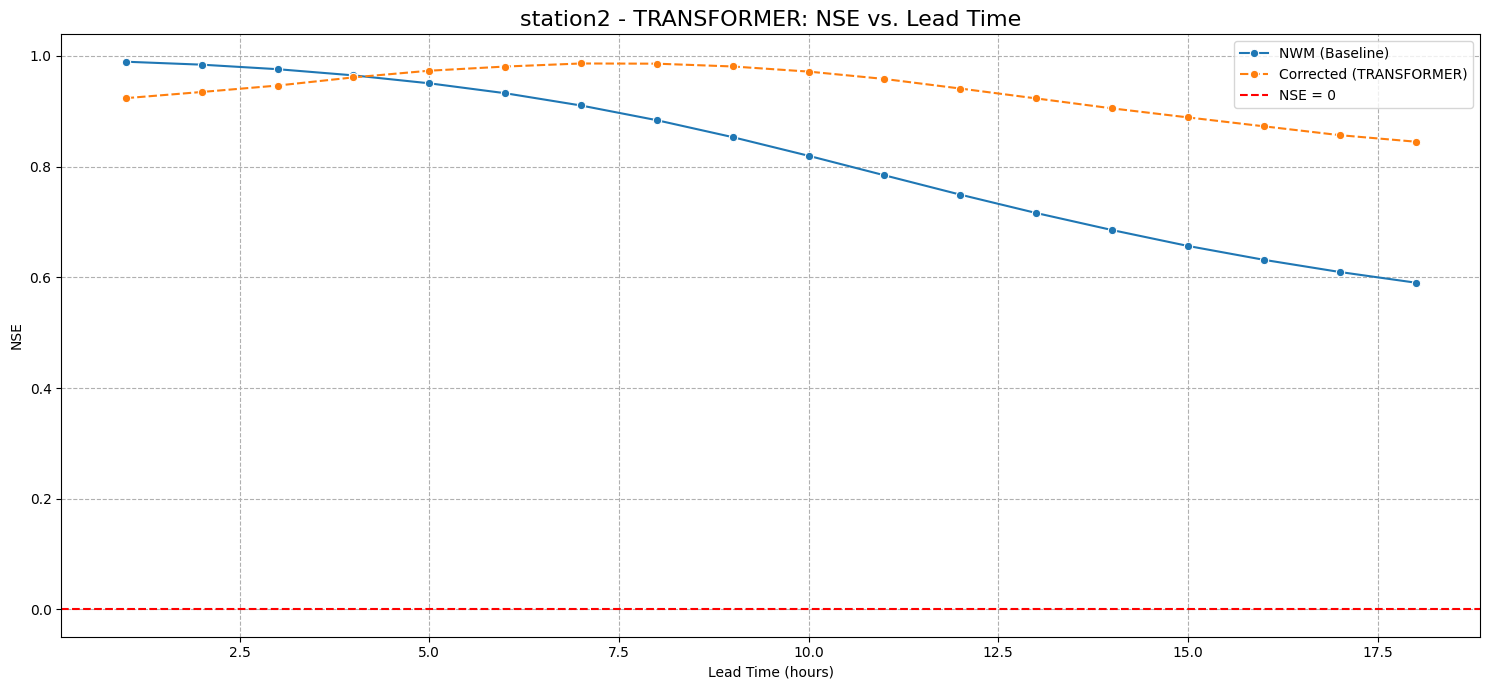

Visualizations complete for TRANSFORMER.


 All evaluation and visualization steps are complete!


In [7]:
all_results = {}
LOOKBACK = 24
MODEL_TYPES = ['rnn', 'lstm', 'transformer']

for station_name, data in station_data.items():
    print(f"\n{'='*60}\n\n///// EVALUATING MODELS FOR {station_name} /////\n")
    all_results[station_name] = {}
    
    X_test = data['X_test']
    scaler = data['scaler']
    
    # Get the original test dataframe to get unscaled values and lead times
    test_start_date = '2022-10-01 00:00:00'
    original_test_df = data['original_featured_df'].loc[test_start_date:].iloc[LOOKBACK:]

    for model_name in MODEL_TYPES:
        print(f"\n--- Processing {model_name.upper()} model ---")
        
        # Load the trained model
        model = keras.models.load_model(models_dir / f"{station_name}_{model_name}_model.keras")
        
        # Make predictions (scaled errors)
        predicted_error_scaled = model.predict(X_test)
        
        # Inverse scale the predictions to get the actual error value
        dummy_array = np.zeros((len(predicted_error_scaled), X_test.shape[2]))
        dummy_array[:, 0] = predicted_error_scaled.ravel()
        predicted_error_unscaled = scaler.inverse_transform(dummy_array)[:, 0]
        
        # Create a results DataFrame and calculate the corrected forecast
        results_df = original_test_df.copy()
        results_df['predicted_error'] = predicted_error_unscaled
        results_df['Corrected_Forecast'] = results_df['NWM_streamflow'] - results_df['predicted_error']

        # Calculate metrics for each lead time
        metrics_by_lead_time = []
        for lead_time, group in results_df.groupby('lead_time'):
            if len(group) < 2: continue
            baseline_metrics = calculate_metrics(group['USGS_streamflow'], group['NWM_streamflow'])
            baseline_metrics.update({'lead_time': lead_time, 'type': 'NWM (Baseline)'})
            
            corrected_metrics = calculate_metrics(group['USGS_streamflow'], group['Corrected_Forecast'])
            corrected_metrics.update({'lead_time': lead_time, 'type': f'Corrected ({model_name.upper()})'})
            
            metrics_by_lead_time.extend([baseline_metrics, corrected_metrics])
            
        metrics_df = pd.DataFrame(metrics_by_lead_time)
        
        # --- Create Runoff Box Plot ---
        plt.figure(figsize=(18, 8))
        plot_data = results_df.rename(columns={'USGS_streamflow': 'Observed', 'NWM_streamflow': 'NWM Baseline', 'Corrected_Forecast': f'{model_name.upper()} Corrected'})
        plot_data = plot_data[['lead_time', 'Observed', 'NWM Baseline', f'{model_name.upper()} Corrected']].melt(id_vars='lead_time', var_name='Forecast Type', value_name='Flow')

        sns.boxplot(data=plot_data, x='lead_time', y='Flow', hue='Forecast Type')
        plt.title(f'{station_name} - {model_name.upper()}: Runoff Comparison by Lead Time', fontsize=16)
        plt.xlabel('Lead Time (hours)'); plt.ylabel('Streamflow (m³/s)')
        plt.legend(title='Forecast Type'); plt.grid(True, linestyle='--')
        plt.tight_layout()
        plt.savefig(figures_dir / f"{station_name}_{model_name}_runoff_boxplot.png")
        plt.show()

        # --- Create Metrics Comparison Plots ---
        for metric in ['CC', 'RMSE', 'PBIAS', 'NSE']:
            plt.figure(figsize=(15, 7))
            sns.lineplot(data=metrics_df, x='lead_time', y=metric, hue='type', marker='o', style='type')
            plt.title(f'{station_name} - {model_name.upper()}: {metric} vs. Lead Time', fontsize=16)
            plt.xlabel('Lead Time (hours)'); plt.ylabel(metric)
            if metric == 'NSE': plt.axhline(0, color='red', linestyle='--', label='NSE = 0')
            plt.legend(); plt.grid(True, linestyle='--')
            plt.tight_layout()
            plt.savefig(figures_dir / f"{station_name}_{model_name}_metric_{metric}.png")
            plt.show()
        
        print(f"Visualizations complete for {model_name.upper()}.")

print("\n\n All evaluation and visualization steps are complete!")